In [ ]:
# 📊 Iteration 3 - Schritt 1: Daten laden und initialisieren

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import mstats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Konfiguration
plt.style.use('default')
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

print("🚀 ITERATION 3: FORTGESCHRITTENES FEATURE ENGINEERING")
print("=" * 60)

# 1. Daten laden und vorbereiten
data_path = '/workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv'
df_raw = pd.read_csv(data_path)

# Datum parsen
df_raw['Datum'] = pd.to_datetime(df_raw['Datum'])

print(f"📈 Rohdaten geladen:")
print(f"   Datensatz-Größe: {df_raw.shape}")
print(f"   Zeitraum: {df_raw['Datum'].min()} bis {df_raw['Datum'].max()}")
print(f"   Warengruppen: {sorted(df_raw['Warengruppe_Name'].unique())}")
print(f"   Umsatz-Bereich: {df_raw['Umsatz'].min():.2f}€ - {df_raw['Umsatz'].max():.2f}€")

# Sample Submission Format prüfen
sample_path = '/workspaces/bakery_sales_prediction/5_Datasets/sample_submission.csv'
try:
    sample_submission = pd.read_csv(sample_path)
    print(f"\n📋 Sample Submission Format:")
    print(f"   Spalten: {list(sample_submission.columns)}")
    print(f"   Einträge: {len(sample_submission)}")
    display(sample_submission.head())
except:
    print("\n⚠️  Sample Submission Datei nicht gefunden")

🚀 ITERATION 3: FORTGESCHRITTENES FEATURE ENGINEERING
📈 Rohdaten geladen:
   Datensatz-Größe: (9334, 35)
   Zeitraum: 2013-07-01 00:00:00 bis 2018-07-31 00:00:00
   Warengruppen: ['Brot', 'Brötchen', 'Croissant', 'Konditorei', 'Kuchen', 'Saisonbrot']
   Umsatz-Bereich: 7.05€ - 1879.46€

📋 Sample Submission Format:
   Spalten: ['id', 'Umsatz']
   Einträge: 1830


,id,Umsatz
0,1808011,0
1,1808021,0
2,1808031,0
3,1808041,0
4,1808051,0


In [ ]:
# 📊 Iteration 3 - Schritt 2: Lag-Features und Rolling-Features erstellen

def create_lag_and_rolling_features(df):
    """
    Erstellt Lag- und Rolling-Features für jede Warengruppe separat
    """
    print("🔄 Erstelle Lag- und Rolling-Features...")
    
    # Kopie für Bearbeitung
    df_features = df.copy()
    
    # Sortieren nach Warengruppe und Datum für korrekte Zeitreihen-Features
    df_features = df_features.sort_values(['Warengruppe_Name', 'Datum']).reset_index(drop=True)
    
    # Initialisiere Listen für neue Features
    lag_features = []
    rolling_features = []
    
    # Für jede Warengruppe separat
    for warengruppe in df_features['Warengruppe_Name'].unique():
        print(f"   Bearbeite Warengruppe: {warengruppe}")
        
        # Maske für aktuelle Warengruppe
        mask = df_features['Warengruppe_Name'] == warengruppe
        
        # Lag-Features (1, 2, 3, 7 Tage zurück)
        for lag in [1, 2, 3, 7]:
            feature_name = f'Umsatz_lag_{lag}_{warengruppe}'
            df_features.loc[mask, feature_name] = df_features.loc[mask, 'Umsatz'].shift(lag)
            lag_features.append(feature_name)
        
        # Rolling-Features (7, 14, 30 Tage gleitender Durchschnitt)
        for window in [7, 14, 30]:
            feature_name = f'Umsatz_roll_{window}_{warengruppe}'
            df_features.loc[mask, feature_name] = (
                df_features.loc[mask, 'Umsatz']
                .rolling(window=window, min_periods=1)
                .mean()
                .shift(1)  # Shift um Data Leakage zu vermeiden
            )
            rolling_features.append(feature_name)
    
    # Basis-Zeitfeatures hinzufügen
    df_features['Wochentag'] = df_features['Datum'].dt.dayofweek  # 0=Montag
    df_features['Monat'] = df_features['Datum'].dt.month
    df_features['Quartal'] = df_features['Datum'].dt.quarter
    df_features['Tag_im_Jahr'] = df_features['Datum'].dt.dayofyear
    df_features['Ist_Wochenende'] = (df_features['Datum'].dt.dayofweek >= 5).astype(int)
    
    time_features = ['Wochentag', 'Monat', 'Quartal', 'Tag_im_Jahr', 'Ist_Wochenende']
    
    print(f"✅ Features erstellt:")
    print(f"   Lag-Features: {len(lag_features)}")
    print(f"   Rolling-Features: {len(rolling_features)}")
    print(f"   Zeit-Features: {len(time_features)}")
    
    return df_features, lag_features, rolling_features, time_features

# Features erstellen
df_with_features, lag_features, rolling_features, time_features = create_lag_and_rolling_features(df_raw)

print(f"\n📊 Dataset nach Feature Engineering:")
print(f"   Neue Größe: {df_with_features.shape}")
print(f"   Neue Spalten: {df_with_features.shape[1] - df_raw.shape[1]}")

# Missing Values prüfen
print(f"\n🔍 Missing Values nach Feature-Erstellung:")
for feature_group, features in [("Lag", lag_features), ("Rolling", rolling_features)]:
    missing_count = df_with_features[features].isnull().sum().sum()
    print(f"   {feature_group}-Features: {missing_count:,} Missing Values")

# Beispiel der ersten Lag/Rolling Features anzeigen
print(f"\n📋 Beispiel Lag-Features (erste 5):")
print(f"   {lag_features[:5]}")
print(f"\n📋 Beispiel Rolling-Features (erste 5):")
print(f"   {rolling_features[:5]}")

🔄 Erstelle Lag- und Rolling-Features...
   Bearbeite Warengruppe: Brot
   Bearbeite Warengruppe: Brötchen
   Bearbeite Warengruppe: Croissant
   Bearbeite Warengruppe: Konditorei
   Bearbeite Warengruppe: Kuchen
   Bearbeite Warengruppe: Saisonbrot
✅ Features erstellt:
   Lag-Features: 24
   Rolling-Features: 18
   Zeit-Features: 5

📊 Dataset nach Feature Engineering:
   Neue Größe: (9334, 80)
   Neue Spalten: 45

🔍 Missing Values nach Feature-Erstellung:
   Lag-Features: 186,758 Missing Values
   Rolling-Features: 140,028 Missing Values

📋 Beispiel Lag-Features (erste 5):
   ['Umsatz_lag_1_Brot', 'Umsatz_lag_2_Brot', 'Umsatz_lag_3_Brot', 'Umsatz_lag_7_Brot', 'Umsatz_lag_1_Brötchen']

📋 Beispiel Rolling-Features (erste 5):
   ['Umsatz_roll_7_Brot', 'Umsatz_roll_14_Brot', 'Umsatz_roll_30_Brot', 'Umsatz_roll_7_Brötchen', 'Umsatz_roll_14_Brötchen']


In [ ]:
# 📊 Iteration 3 - Schritt 3: Missing Value Handling und Winsorisierung

def handle_missing_values_and_winsorize(df, lag_features, rolling_features, time_features):
    """
    Behandelt Missing Values und führt Winsorisierung durch
    """
    print("🧹 Behandle Missing Values und führe Winsorisierung durch...")
    
    df_clean = df.copy()
    
    # 1. Missing Values in Lag/Rolling Features behandeln
    print("   📊 Missing Values Statistics vor Behandlung:")
    
    # Alle numerischen Features sammeln
    numeric_features = (['Umsatz'] + lag_features + rolling_features + time_features + 
                       ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung'])
    
    # Nur verfügbare Features verwenden
    available_numeric = [col for col in numeric_features if col in df_clean.columns]
    
    # Missing Values pro Feature
    missing_before = df_clean[available_numeric].isnull().sum()
    print(f"      Features mit Missing Values: {(missing_before > 0).sum()}")
    print(f"      Total Missing Values: {missing_before.sum()}")
    
    # 2. Missing Values füllen
    # Für Lag/Rolling Features: Forward Fill innerhalb jeder Warengruppe
    for warengruppe in df_clean['Warengruppe_Name'].unique():
        mask = df_clean['Warengruppe_Name'] == warengruppe
        
        # Lag Features: Forward Fill, dann 0
        for feature in lag_features:
            if feature in df_clean.columns:
                df_clean.loc[mask, feature] = (df_clean.loc[mask, feature]
                                               .fillna(method='ffill')
                                               .fillna(0))
        
        # Rolling Features: Forward Fill, dann mit Umsatz-Mittelwert der Gruppe
        for feature in rolling_features:
            if feature in df_clean.columns:
                group_mean = df_clean.loc[mask, 'Umsatz'].mean()
                df_clean.loc[mask, feature] = (df_clean.loc[mask, feature]
                                               .fillna(method='ffill')
                                               .fillna(group_mean))
    
    # 3. Winsorisierung (1% und 99% Perzentile)
    print("   📏 Führe Winsorisierung durch (1% - 99% Perzentile)...")
    
    # Features für Winsorisierung (nur kontinuierliche numerische Features)
    winsorize_features = ['Umsatz'] + lag_features + rolling_features
    winsorize_features += ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']
    winsorize_features = [col for col in winsorize_features if col in df_clean.columns]
    
    winsorized_stats = {}
    
    for feature in winsorize_features:
        # Original-Statistiken
        orig_min, orig_max = df_clean[feature].min(), df_clean[feature].max()
        
        # Winsorisierung
        df_clean[feature] = mstats.winsorize(df_clean[feature], limits=[0.01, 0.01])
        
        # Neue Statistiken
        new_min, new_max = df_clean[feature].min(), df_clean[feature].max()
        
        winsorized_stats[feature] = {
            'orig_range': (orig_min, orig_max),
            'new_range': (new_min, new_max),
            'clipped': (orig_min != new_min) or (orig_max != new_max)
        }
    
    # 4. Final Missing Value Check
    missing_after = df_clean[available_numeric].isnull().sum()
    print(f"   ✅ Missing Values nach Behandlung: {missing_after.sum()}")
    
    # 5. Winsorisierung Statistiken
    clipped_features = [f for f, stats in winsorized_stats.items() if stats['clipped']]
    print(f"   ✅ Winsorisierte Features: {len(clipped_features)}")
    
    if clipped_features:
        print("      Beispiele:")
        for feature in clipped_features[:3]:
            stats = winsorized_stats[feature]
            orig_min, orig_max = stats['orig_range']
            new_min, new_max = stats['new_range']
            print(f"         {feature}: [{orig_min:.2f}, {orig_max:.2f}] → [{new_min:.2f}, {new_max:.2f}]")
    
    return df_clean, winsorized_stats

# Missing Value Handling und Winsorisierung anwenden
df_processed, winsorized_stats = handle_missing_values_and_winsorize(
    df_with_features, lag_features, rolling_features, time_features
)

print(f"\n📊 Dataset nach Preprocessing:")
print(f"   Größe: {df_processed.shape}")
print(f"   Missing Values: {df_processed.isnull().sum().sum()}")
print(f"   Zeitraum: {df_processed['Datum'].min()} bis {df_processed['Datum'].max()}")

# Datenqualität pro Warengruppe prüfen
print(f"\n🔍 Datenqualität pro Warengruppe:")
for warengruppe in sorted(df_processed['Warengruppe_Name'].unique()):
    wg_data = df_processed[df_processed['Warengruppe_Name'] == warengruppe]
    missing = wg_data.isnull().sum().sum()
    print(f"   {warengruppe}: {len(wg_data)} Zeilen, {missing} Missing Values")

🧹 Behandle Missing Values und führe Winsorisierung durch...
   📊 Missing Values Statistics vor Behandlung:
      Features mit Missing Values: 42
      Total Missing Values: 326786
   📏 Führe Winsorisierung durch (1% - 99% Perzentile)...
   ✅ Missing Values nach Behandlung: 0
   ✅ Winsorisierte Features: 39
      Beispiele:
         Umsatz: [7.05, 1879.46] → [39.36, 669.19]
         Umsatz_lag_1_Brot: [0.00, 416.79] → [0.00, 187.24]
         Umsatz_lag_2_Brot: [0.00, 416.79] → [0.00, 187.24]

📊 Dataset nach Preprocessing:
   Größe: (9334, 80)
   Missing Values: 0
   Zeitraum: 2013-07-01 00:00:00 bis 2018-07-31 00:00:00

🔍 Datenqualität pro Warengruppe:
   Brot: 1819 Zeilen, 0 Missing Values
   Brötchen: 1819 Zeilen, 0 Missing Values
   Croissant: 1819 Zeilen, 0 Missing Values
   Konditorei: 1766 Zeilen, 0 Missing Values
   Kuchen: 1819 Zeilen, 0 Missing Values
   Saisonbrot: 292 Zeilen, 0 Missing Values
   📏 Führe Winsorisierung durch (1% - 99% Perzentile)...
   ✅ Missing Values nach Be

In [ ]:
# 📊 Iteration 3 - Schritt 4: Präzise zeitliche Datenaufteilung

def create_time_based_splits(df):
    """
    Erstellt zeitbasierte Splits mit exakten Datumsgrenzen
    """
    print("📅 Erstelle zeitbasierte Datenaufteilung...")
    
    # Definiere Split-Grenzen
    train_start = pd.to_datetime('2013-07-01')
    train_end = pd.to_datetime('2017-07-31')
    val_start = pd.to_datetime('2017-08-01')
    val_end = pd.to_datetime('2018-07-31')
    test_start = pd.to_datetime('2018-08-01')
    test_end = pd.to_datetime('2019-07-31')
    
    # Sortiere nach Datum
    df_sorted = df.sort_values('Datum').reset_index(drop=True)
    
    # Erstelle Masken
    train_mask = (df_sorted['Datum'] >= train_start) & (df_sorted['Datum'] <= train_end)
    val_mask = (df_sorted['Datum'] >= val_start) & (df_sorted['Datum'] <= val_end)
    test_mask = (df_sorted['Datum'] >= test_start) & (df_sorted['Datum'] <= test_end)
    
    # Splits erstellen
    train_df = df_sorted[train_mask].copy()
    val_df = df_sorted[val_mask].copy()
    test_df = df_sorted[test_mask].copy()
    
    print(f"✅ Datenaufteilung erstellt:")
    print(f"   Training:   {train_df['Datum'].min()} bis {train_df['Datum'].max()} ({len(train_df):,} Zeilen)")
    print(f"   Validation: {val_df['Datum'].min()} bis {val_df['Datum'].max()} ({len(val_df):,} Zeilen)")
    print(f"   Test:       {test_df['Datum'].min()} bis {test_df['Datum'].max()} ({len(test_df):,} Zeilen)")
    
    # Warengruppen-Verteilung prüfen
    print(f"\n📊 Warengruppen-Verteilung:")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        warengruppen = split_df['Warengruppe_Name'].nunique()
        print(f"   {split_name}: {warengruppen} Warengruppen")
        
        # Details für jede Warengruppe
        for wg in sorted(split_df['Warengruppe_Name'].unique()):
            count = len(split_df[split_df['Warengruppe_Name'] == wg])
            print(f"      {wg}: {count} Datenpunkte")
    
    return train_df, val_df, test_df

# Zeitliche Aufteilung durchführen
train_df_v3, val_df_v3, test_df_v3 = create_time_based_splits(df_processed)

# Überprüfe Kontinuität der Zeitreihen
print(f"\n🔍 Zeitreihen-Kontinuität Check:")

def check_time_continuity(df, split_name):
    """Prüft Kontinuität der Zeitreihen pro Warengruppe"""
    print(f"   {split_name}:")
    for wg in sorted(df['Warengruppe_Name'].unique()):
        wg_data = df[df['Warengruppe_Name'] == wg].sort_values('Datum')
        date_diffs = wg_data['Datum'].diff().dt.days
        
        # Überspringe erste NaN
        date_diffs = date_diffs.dropna()
        
        if len(date_diffs) > 0:
            avg_gap = date_diffs.mean()
            max_gap = date_diffs.max()
            gaps_over_1 = (date_diffs > 1).sum()
            print(f"      {wg}: Ø {avg_gap:.1f} Tage, Max: {max_gap:.0f} Tage, Lücken >1 Tag: {gaps_over_1}")

for split_name, split_df in [("Training", train_df_v3), ("Validation", val_df_v3), ("Test", test_df_v3)]:
    check_time_continuity(split_df, split_name)

📅 Erstelle zeitbasierte Datenaufteilung...
✅ Datenaufteilung erstellt:
   Training:   2013-07-01 00:00:00 bis 2017-07-31 00:00:00 (7,493 Zeilen)
   Validation: 2017-08-01 00:00:00 bis 2018-07-31 00:00:00 (1,841 Zeilen)
   Test:       NaT bis NaT (0 Zeilen)

📊 Warengruppen-Verteilung:
   Train: 6 Warengruppen
      Brot: 1462 Datenpunkte
      Brötchen: 1462 Datenpunkte
      Croissant: 1462 Datenpunkte
      Konditorei: 1409 Datenpunkte
      Kuchen: 1462 Datenpunkte
      Saisonbrot: 236 Datenpunkte
   Val: 6 Warengruppen
      Brot: 357 Datenpunkte
      Brötchen: 357 Datenpunkte
      Croissant: 357 Datenpunkte
      Konditorei: 357 Datenpunkte
      Kuchen: 357 Datenpunkte
      Saisonbrot: 56 Datenpunkte
   Test: 0 Warengruppen

🔍 Zeitreihen-Kontinuität Check:
   Training:
      Brot: Ø 1.0 Tage, Max: 3 Tage, Lücken >1 Tag: 23
      Brötchen: Ø 1.0 Tage, Max: 3 Tage, Lücken >1 Tag: 23
      Croissant: Ø 1.0 Tage, Max: 3 Tage, Lücken >1 Tag: 23
      Konditorei: Ø 1.1 Tage, Max: 6 

In [ ]:
# 📊 Iteration 3 - Schritt 5: Feature-Skalierung und Vorbereitung

def prepare_features_for_modeling(train_df, val_df, test_df, lag_features, rolling_features, time_features):
    """
    Bereitet Features vor: identifiziert numerische Features und skaliert nur diese
    """
    print("🔧 Bereite Features für Modellierung vor...")
    
    # Basis-Features definieren
    base_features = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']
    
    # Alle potenziellen numerischen Features
    potential_numeric = base_features + lag_features + rolling_features + time_features
    
    # Nur verfügbare Features verwenden
    numeric_features = [col for col in potential_numeric if col in train_df.columns]
    
    # One-Hot Features für Warengruppen (diese NICHT skalieren)
    onehot_features = [col for col in train_df.columns if col.startswith('Warengruppe_')]
    
    print(f"   📊 Feature-Kategorien:")
    print(f"      Numerische Features (zu skalieren): {len(numeric_features)}")
    print(f"      One-Hot Features (nicht skalieren): {len(onehot_features)}")
    
    # Feature-Matrix für jede Warengruppe vorbereiten
    prepared_data = {}
    scalers = {}
    
    for warengruppe in sorted(train_df['Warengruppe_Name'].unique()):
        print(f"   🔄 Bearbeite Warengruppe: {warengruppe}")
        
        # Daten für aktuelle Warengruppe filtern
        train_wg = train_df[train_df['Warengruppe_Name'] == warengruppe].copy()
        val_wg = val_df[val_df['Warengruppe_Name'] == warengruppe].copy()
        test_wg = test_df[test_df['Warengruppe_Name'] == warengruppe].copy()
        
        # Relevante Lag/Rolling Features für diese Warengruppe
        wg_lag_features = [f for f in lag_features if warengruppe in f]
        wg_rolling_features = [f for f in rolling_features if warengruppe in f]
        
        # Final Feature List für diese Warengruppe
        wg_numeric_features = (base_features + time_features + 
                              wg_lag_features + wg_rolling_features)
        wg_numeric_features = [f for f in wg_numeric_features if f in train_wg.columns]
        
        # Feature-Matrix erstellen
        X_train_numeric = train_wg[wg_numeric_features].values
        X_val_numeric = val_wg[wg_numeric_features].values
        X_test_numeric = test_wg[wg_numeric_features].values
        
        # Target-Variable
        y_train = train_wg['Umsatz'].values
        y_val = val_wg['Umsatz'].values
        y_test = test_wg['Umsatz'].values
        
        # Skalierung nur für numerische Features
        scaler_X = StandardScaler()\n        X_train_scaled = scaler_X.fit_transform(X_train_numeric)
        X_val_scaled = scaler_X.transform(X_val_numeric)
        X_test_scaled = scaler_X.transform(X_test_numeric)
        
        # Target skalieren
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
        
        # Daten speichern
        prepared_data[warengruppe] = {
            'X_train': X_train_scaled, 'y_train': y_train_scaled,
            'X_val': X_val_scaled, 'y_val': y_val_scaled,
            'X_test': X_test_scaled, 'y_test': y_test_scaled,
            'y_train_orig': y_train, 'y_val_orig': y_val, 'y_test_orig': y_test,
            'feature_names': wg_numeric_features,
            'train_dates': train_wg['Datum'].values,
            'val_dates': val_wg['Datum'].values,
            'test_dates': test_wg['Datum'].values
        }
        
        scalers[warengruppe] = {
            'scaler_X': scaler_X,
            'scaler_y': scaler_y
        }
        
        print(f"      Features: {len(wg_numeric_features)}")
        print(f"      Train/Val/Test: {len(y_train)}/{len(y_val)}/{len(y_test)}")
    
    return prepared_data, scalers

# Feature-Vorbereitung durchführen
prepared_data_v3, scalers_v3 = prepare_features_for_modeling(
    train_df_v3, val_df_v3, test_df_v3, lag_features, rolling_features, time_features
)

print(f"\n✅ Feature-Vorbereitung abgeschlossen:")
print(f"   Warengruppen: {len(prepared_data_v3)}")

# Zusammenfassung der vorbereiteten Daten
print(f"\n📊 Zusammenfassung pro Warengruppe:")
for warengruppe, data in prepared_data_v3.items():
    n_features = data['X_train'].shape[1]
    n_train = len(data['y_train'])
    n_val = len(data['y_val'])
    n_test = len(data['y_test'])
    print(f"   {warengruppe}:")
    print(f"      Features: {n_features}")
    print(f"      Daten: Train={n_train}, Val={n_val}, Test={n_test}")
    print(f"      Feature-Beispiele: {data['feature_names'][:3]}...")

SyntaxError: unexpected character after line continuation character (3676473931.py, line 57)

In [ ]:
# 📊 Iteration 3 - Schritt 6: Warengruppen-spezifische neuronale Netzwerke

def create_warengruppe_model(input_dim, warengruppe_name):
    """
    Erstellt ein warengruppen-spezifisches neuronales Netzwerk
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,), name=f'dense1_{warengruppe_name}'),
        Dropout(0.3),
        Dense(64, activation='relu', name=f'dense2_{warengruppe_name}'),
        Dropout(0.2),
        Dense(32, activation='relu', name=f'dense3_{warengruppe_name}'),
        Dense(1, activation='linear', name=f'output_{warengruppe_name}')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_warengruppe_models(prepared_data, scalers):
    """
    Trainiert für jede Warengruppe ein separates Modell
    """
    print("🚀 Trainiere warengruppen-spezifische Modelle...")
    
    models = {}
    training_histories = {}
    
    for warengruppe, data in prepared_data.items():
        print(f"\n🔄 Trainiere Modell für: {warengruppe}")
        print(f"   Input-Dimension: {data['X_train'].shape[1]}")
        print(f"   Training Samples: {len(data['y_train'])}")
        
        # Modell erstellen
        model = create_warengruppe_model(data['X_train'].shape[1], warengruppe)
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        # Training
        history = model.fit(
            data['X_train'], data['y_train'],
            validation_data=(data['X_val'], data['y_val']),
            epochs=100,
            batch_size=min(32, len(data['X_train']) // 4),  # Anpassung für kleinere Warengruppen
            callbacks=callbacks,
            verbose=0
        )
        
        # Ergebnisse speichern
        models[warengruppe] = model
        training_histories[warengruppe] = history
        
        # Training-Statistiken
        best_val_loss = min(history.history['val_loss'])
        final_epoch = len(history.history['loss'])
        
        print(f"   ✅ Training abgeschlossen:")
        print(f"      Epochen: {final_epoch}")
        print(f"      Beste Val Loss: {best_val_loss:.4f}")
        print(f"      Parameter: {model.count_params():,}")
    
    return models, training_histories

# Modelle trainieren
print("🧠 STARTE WARENGRUPPEN-SPEZIFISCHES TRAINING")
print("=" * 60)

models_v3, histories_v3 = train_warengruppe_models(prepared_data_v3, scalers_v3)

print(f"\n✅ Alle Modelle trainiert!")
print(f"   Anzahl Modelle: {len(models_v3)}")

# Training-Zusammenfassung
print(f"\n📊 Training-Zusammenfassung:")
total_params = 0
for warengruppe, model in models_v3.items():
    history = histories_v3[warengruppe]
    params = model.count_params()
    total_params += params
    
    best_val_loss = min(history.history['val_loss'])
    epochs = len(history.history['loss'])
    
    print(f"   {warengruppe}:")
    print(f"      Parameter: {params:,}")
    print(f"      Epochen: {epochs}")
    print(f"      Beste Val Loss: {best_val_loss:.4f}")

print(f"\n🎯 Gesamt-Parameter aller Modelle: {total_params:,}")

In [ ]:
# 📊 Iteration 3 - Schritt 7: Evaluation und Vorhersagen

def evaluate_warengruppe_models(models, prepared_data, scalers):
    """
    Evaluiert alle warengruppen-spezifischen Modelle
    """
    print("📊 Evaluiere warengruppen-spezifische Modelle...")
    
    evaluation_results = {}
    all_predictions = {}
    
    for warengruppe in models.keys():
        print(f"\n🔍 Evaluiere: {warengruppe}")
        
        model = models[warengruppe]
        data = prepared_data[warengruppe]
        scaler_y = scalers[warengruppe]['scaler_y']
        
        # Vorhersagen für alle Splits
        results = {}
        
        for split in ['train', 'val', 'test']:
            X_key = f'X_{split}'
            y_key = f'y_{split}'
            y_orig_key = f'y_{split}_orig'
            
            # Vorhersagen (skaliert)
            y_pred_scaled = model.predict(data[X_key], verbose=0).ravel()
            
            # Rückskalierung
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
            y_true = data[y_orig_key]
            
            # Negative Vorhersagen auf 0 setzen
            y_pred = np.maximum(y_pred, 0)
            
            # Metriken berechnen
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            results[split] = {
                'mae': mae,
                'rmse': rmse,
                'y_true': y_true,
                'y_pred': y_pred,
                'dates': data[f'{split}_dates'] if f'{split}_dates' in data else None
            }
            
            print(f"   {split.upper()}: MAE={mae:.2f}€, RMSE={rmse:.2f}€")
        
        evaluation_results[warengruppe] = results
        
        # Test-Vorhersagen für finale Submission
        all_predictions[warengruppe] = {
            'dates': data['test_dates'],
            'predictions': results['test']['y_pred']
        }
    
    return evaluation_results, all_predictions

def create_submission_format(all_predictions, test_df):
    """
    Erstellt Vorhersagen im Sample Submission Format
    """
    print("📝 Erstelle Submission-Format...")
    
    submission_data = []
    
    for warengruppe, pred_data in all_predictions.items():
        dates = pred_data['dates']
        predictions = pred_data['predictions']
        
        for date, prediction in zip(dates, predictions):
            submission_data.append({
                'Datum': date,
                'Warengruppe_Name': warengruppe,
                'Umsatz': prediction
            })
    
    submission_df = pd.DataFrame(submission_data)
    submission_df['Datum'] = pd.to_datetime(submission_df['Datum'])
    submission_df = submission_df.sort_values(['Datum', 'Warengruppe_Name'])
    
    print(f"   ✅ Submission erstellt:")
    print(f"      Einträge: {len(submission_df)}")
    print(f"      Zeitraum: {submission_df['Datum'].min()} bis {submission_df['Datum'].max()}")
    print(f"      Warengruppen: {submission_df['Warengruppe_Name'].nunique()}")
    
    return submission_df

# Evaluation durchführen
print("🎯 EVALUATION DER WARENGRUPPEN-MODELLE")
print("=" * 60)

evaluation_results_v3, predictions_v3 = evaluate_warengruppe_models(
    models_v3, prepared_data_v3, scalers_v3
)

# Gesamt-Performance berechnen
print(f"\n📊 GESAMT-PERFORMANCE (Test-Set):")
print("=" * 50)

total_mae = 0
total_rmse = 0
total_samples = 0

for warengruppe, results in evaluation_results_v3.items():
    test_results = results['test']
    n_samples = len(test_results['y_true'])
    
    total_mae += test_results['mae'] * n_samples
    total_rmse += test_results['rmse'] * n_samples
    total_samples += n_samples

# Gewichtete Durchschnitte
overall_mae = total_mae / total_samples
overall_rmse = total_rmse / total_samples

print(f"Gewichteter Durchschnitt:")
print(f"   MAE:  {overall_mae:.2f}€")
print(f"   RMSE: {overall_rmse:.2f}€")
print(f"   Samples: {total_samples}")

# Submission erstellen
submission_v3 = create_submission_format(predictions_v3, test_df_v3)

# Speichern
output_path = '/workspaces/bakery_sales_prediction/3_Model/prediction_neural_net_v3.csv'
submission_v3.to_csv(output_path, index=False)

print(f"\n💾 Vorhersagen gespeichert: prediction_neural_net_v3.csv")
print(f"   Erste 5 Zeilen:")
display(submission_v3.head())

🎯 EVALUATION DER WARENGRUPPEN-MODELLE


NameError: name 'models_v3' is not defined

In [ ]:
# 📊 Iteration 3 - Schritt 8: Visualisierung und finale Zusammenfassung

def visualize_iteration3_results(evaluation_results, histories):
    """
    Visualisiert die Ergebnisse von Iteration 3
    """
    print("📈 Erstelle Visualisierungen...")
    
    # 1. Performance-Vergleich der Warengruppen
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Test MAE pro Warengruppe
    warengruppen = list(evaluation_results.keys())
    test_maes = [evaluation_results[wg]['test']['mae'] for wg in warengruppen]
    test_rmses = [evaluation_results[wg]['test']['rmse'] for wg in warengruppen]
    
    ax1.bar(warengruppen, test_maes, color='skyblue', alpha=0.7)
    ax1.set_title('Test MAE pro Warengruppe')
    ax1.set_ylabel('MAE (€)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Test RMSE pro Warengruppe
    ax2.bar(warengruppen, test_rmses, color='lightcoral', alpha=0.7)
    ax2.set_title('Test RMSE pro Warengruppe')
    ax2.set_ylabel('RMSE (€)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Training History für eine ausgewählte Warengruppe (erste)
    if warengruppen:
        example_wg = warengruppen[0]
        history = histories[example_wg]
        
        ax3.plot(history.history['loss'], label='Training Loss', alpha=0.8)
        ax3.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
        ax3.set_title(f'Training History: {example_wg}')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Vorhersage vs Tatsächlich für Beispiel-Warengruppe
        test_results = evaluation_results[example_wg]['test']
        ax4.scatter(test_results['y_true'], test_results['y_pred'], alpha=0.6, color='green')
        ax4.plot([test_results['y_true'].min(), test_results['y_true'].max()], 
                 [test_results['y_true'].min(), test_results['y_true'].max()], 'r--', lw=2)
        ax4.set_xlabel('Tatsächlicher Umsatz (€)')
        ax4.set_ylabel('Vorhergesagter Umsatz (€)')
        ax4.set_title(f'Vorhersagen vs Tatsächlich: {example_wg}')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Feature-Wichtigkeit für Beispiel-Warengruppe
    if warengruppen:
        print(f"\n🔍 Feature-Analyse für {example_wg}:")
        model = models_v3[example_wg]
        weights = model.layers[0].get_weights()[0]
        feature_importance = np.abs(weights).mean(axis=1)
        feature_names = prepared_data_v3[example_wg]['feature_names']
        
        top_features_idx = np.argsort(feature_importance)[-10:][::-1]
        
        print("   Top 10 Features:")
        for i, idx in enumerate(top_features_idx, 1):
            if idx < len(feature_names):
                print(f"   {i:2d}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

# Visualisierung ausführen
visualize_iteration3_results(evaluation_results_v3, histories_v3)

# Finale Zusammenfassung
print(f"\n🏆 ITERATION 3 - FINALE ZUSAMMENFASSUNG")
print("=" * 80)

print(f"\n🎯 IMPLEMENTIERTE FEATURES:")
print("✅ Lag-Features (1, 2, 3, 7 Tage) pro Warengruppe")
print("✅ Rolling-Features (7, 14, 30 Tage Mittelwerte) pro Warengruppe")
print("✅ Winsorisierung (1%-99% Perzentile) für Ausreißer-Robustheit")
print("✅ Separate neuronale Netzwerke pro Warengruppe")
print("✅ Zeitliche Datenaufteilung ohne Data Leakage")
print("✅ Korrekte Feature-Skalierung (nur numerische Features)")
print("✅ Missing Value Handling für Zeitreihen")

print(f"\n📊 MODELL-ARCHITEKTUR:")
print("   Warengruppen-spezifisch: Dense(128) → Dropout(0.3) → Dense(64) → Dropout(0.2) → Dense(32) → Dense(1)")
print(f"   Anzahl Modelle: {len(models_v3)}")

total_params = sum(model.count_params() for model in models_v3.values())
print(f"   Gesamt-Parameter: {total_params:,}")

print(f"\n🎯 PERFORMANCE (Test-Set):")
print(f"   Gewichteter Durchschnitt MAE: {overall_mae:.2f}€")
print(f"   Gewichteter Durchschnitt RMSE: {overall_rmse:.2f}€")

print(f"\n📋 PERFORMANCE PRO WARENGRUPPE:")
for warengruppe in sorted(evaluation_results_v3.keys()):
    results = evaluation_results_v3[warengruppe]['test']
    print(f"   {warengruppe}: MAE={results['mae']:.2f}€, RMSE={results['rmse']:.2f}€")

print(f"\n💾 OUTPUT:")
print("✅ prediction_neural_net_v3.csv: Vorhersagen im Submission-Format")
print(f"✅ {len(submission_v3)} Vorhersagen für {submission_v3['Warengruppe_Name'].nunique()} Warengruppen")

print(f"\n🚀 VORTEILE VON ITERATION 3:")
print("• Warengruppen-spezifische Modellierung für bessere Anpassung")
print("• Lag/Rolling Features für Zeitreihen-Muster")
print("• Robuste Ausreißerbehandlung durch Winsorisierung")
print("• Korrekte zeitliche Validierung ohne Data Leakage")
print("• Saubere Feature-Engineering-Pipeline")

print("\n" + "="*80)
print("🎉 ITERATION 3 ERFOLGREICH ABGESCHLOSSEN!")
print("="*80)

NameError: name 'evaluation_results_v3' is not defined

# Zusammenfassung und Vergleich der Iterationen

## Modell-Vergleich

### Iteration 1: Basis-Modell
- **Features**: Grundlegende Zeit-Features (Wochentag, Monat), One-Hot Warengruppe, Wetter-Features
- **Architektur**: Einfaches 3-Layer Netzwerk (64 → 32 → 1)
- **Parameter**: ~6,000 Parameter

### Iteration 2: Erweiterte Modell
- **Features**: Erweiterte Zeit-Features (Quartal, Wochenende, Kalenderwoche) + Interaktionen (Warengruppe × Wochentag/Monat)
- **Architektur**: Größeres 4-Layer Netzwerk (128 → 64 → 32 → 1) mit Dropout
- **Parameter**: ~50,000+ Parameter

## Performance-Verbesserung
- **Mehr Features**: Von ~20 auf ~300+ Features durch Interaktionen
- **Komplexere Architektur**: Tieferes Netzwerk mit Regularisierung
- **Bessere Generalisierung**: Durch Dropout und Early Stopping

## Nächste Schritte (Iteration 3)
1. **Lag-Features**: Umsatz der Vortage als Features
2. **Rolling-Features**: Gleitende Durchschnitte über verschiedene Zeitfenster
3. **Gruppen-spezifische Modelle**: Separate Modelle für verschiedene Warengruppen
4. **Hyperparameter-Tuning**: Systematische Optimierung der Modell-Parameter
5. **Regularisierung**: L1/L2 Regularisierung, weitere Dropout-Strategien

## Dateien erstellt
- `prediction_neural_net.csv`: Vorhersagen Iteration 1
- `prediction_neural_net_v2.csv`: Vorhersagen Iteration 2

In [ ]:
# Iteration 2: Speichern der Vorhersagen
def save_predictions_extended(results, original_data, output_path):
    """Speichert die Vorhersagen des erweiterten Modells"""
    # Test-Daten mit Vorhersagen kombinieren
    test_df_extended = original_data['test']['df'].copy()
    test_df_extended['predicted_sales'] = results['test']['y_pred']
    test_df_extended['actual_sales'] = results['test']['y_true']
    test_df_extended['absolute_error'] = np.abs(test_df_extended['actual_sales'] - test_df_extended['predicted_sales'])
    test_df_extended['relative_error'] = (test_df_extended['absolute_error'] / test_df_extended['actual_sales']) * 100
    
    # Für Submission Format
    prediction_df_extended = test_df_extended[['date', 'Warengruppe', 'predicted_sales']].copy()
    prediction_df_extended.columns = ['date', 'Warengruppe', 'Umsatz']
    
    # Speichern
    prediction_df_extended.to_csv(output_path, index=False)
    
    return prediction_df_extended, test_df_extended

# Vorhersagen speichern
print("Speichere Vorhersagen des erweiterten Modells...")
prediction_df_v2, test_results_v2 = save_predictions_extended(
    results_extended, 
    data_extended_prepared['original'], 
    '/workspaces/bakery_sales_prediction/3_Model/prediction_neural_net_v2.csv'
)

print(f"Vorhersagen gespeichert: prediction_neural_net_v2.csv")
print(f"Anzahl Vorhersagen: {len(prediction_df_v2)}")

# Stataidstiken der Vorhersagen
print(f"\nVorhersage-Statistiken (Iteration 2):")
print(f"Durchschnittliche Vorhersage: {prediction_df_v2['Umsatz'].mean():.2f} €")
print(f"Median Vorhersage: {prediction_df_v2['Umsatz'].median():.2f} €")
print(f"Min Vorhersage: {prediction_df_v2['Umsatz'].min():.2f} €")
print(f"Max Vorhersage: {prediction_df_v2['Umsatz'].max():.2f} €")

# Vergleich der Vorhersage-Verteilungen
print(f"\nFehler-Statistiken (Test-Set):")
print(f"Durchschnittlicher absoluter Fehler: {test_results_v2['absolute_error'].mean():.2f} €")
print(f"Median absoluter Fehler: {test_results_v2['absolute_error'].median():.2f} €")
print(f"Durchschnittlicher relativer Fehler: {test_results_v2['relative_error'].mean():.1f}%")
print(f"Median relativer Fehler: {test_results_v2['relative_error'].median():.1f}%")

Speichere Vorhersagen des erweiterten Modells...


NameError: name 'results_extended' is not defined

In [ ]:
# Iteration 2: Evaluation des erweiterten Modells
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_extended_model(model, data):
    """Evaluiert das erweiterte Modell auf allen Datensätzen"""
    results = {}
    
    # Für jede Datenaufteilung
    for split in ['train', 'val', 'test']:
        X_key = f'X_{split}'
        y_key = f'y_{split}'
        y_orig_key = f'y_{split}_orig'
        
        # Vorhersagen erstellen (skaliert)
        y_pred_scaled = model.predict(data[X_key], verbose=0).ravel()
        
        # Rückskalierung
        y_pred = data['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_true = data[y_orig_key]
        
        # Metriken berechnen
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        results[split] = {
            'mae': mae,
            'rmse': rmse,
            'y_true': y_true,
            'y_pred': y_pred
        }
    
    return results

# Evaluation des erweiterten Modells
print("📊 EVALUIERE ERWEITERTES MODELL (ITERATION 2)")
print("=" * 60)

results_v2 = evaluate_extended_model(model_v2, data_v2)

# Ergebnisse anzeigen
print("ITERATION 2 - ERWEITERTE MODELL ERGEBNISSE")
print("=" * 50)

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    print(f"  MAE:  {results_v2[split]['mae']:.2f} €")
    print(f"  RMSE: {results_v2[split]['rmse']:.2f} €")

# Vergleich mit Iteration 1 (falls verfügbar)
print("\n" + "="*60)
print("VERGLEICH: ITERATION 1 vs ITERATION 2")
print("="*60)

if 'results' in locals() and isinstance(results, dict):
    for split in ['test']:  # Fokus auf Test-Performance
        if split in results:
            iter1_mae = results[split]['mae']
            iter1_rmse = results[split]['rmse']
            iter2_mae = results_v2[split]['mae']
            iter2_rmse = results_v2[split]['rmse']
            
            mae_improvement = ((iter1_mae - iter2_mae) / iter1_mae) * 100
            rmse_improvement = ((iter1_rmse - iter2_rmse) / iter1_rmse) * 100
            
            print(f"\n{split.upper()}-SET PERFORMANCE:")
            print(f"  Iteration 1 - MAE: {iter1_mae:.2f} €, RMSE: {iter1_rmse:.2f} €")
            print(f"  Iteration 2 - MAE: {iter2_mae:.2f} €, RMSE: {iter2_rmse:.2f} €")
            print(f"  Verbesserung - MAE: {mae_improvement:+.1f}%, RMSE: {rmse_improvement:+.1f}%")
        else:
            print(f"Split '{split}' nicht in Iteration 1 verfügbar")
else:
    print("Iteration 1 Ergebnisse nicht verfügbar für Vergleich")
    
print(f"\n📊 ITERATION 2 ZUSAMMENFASSUNG:")
print("=" * 40)
print(f"Test MAE: {results_v2['test']['mae']:.2f} €")
print(f"Test RMSE: {results_v2['test']['rmse']:.2f} €")
print(f"Features verwendet: {input_dim_v2}")
print(f"Modell-Parameter: {model_v2.count_params():,}")

📊 EVALUIERE ERWEITERTES MODELL (ITERATION 2)
ITERATION 2 - ERWEITERTE MODELL ERGEBNISSE

TRAIN:
  MAE:  37.40 €
  RMSE: 63.18 €

VAL:
  MAE:  35.68 €
  RMSE: 53.16 €

TEST:
  MAE:  38.77 €
  RMSE: 51.53 €

VERGLEICH: ITERATION 1 vs ITERATION 2
Split 'test' nicht in Iteration 1 verfügbar

📊 ITERATION 2 ZUSAMMENFASSUNG:
Test MAE: 38.77 €
Test RMSE: 51.53 €
Features verwendet: 134
Modell-Parameter: 27,649


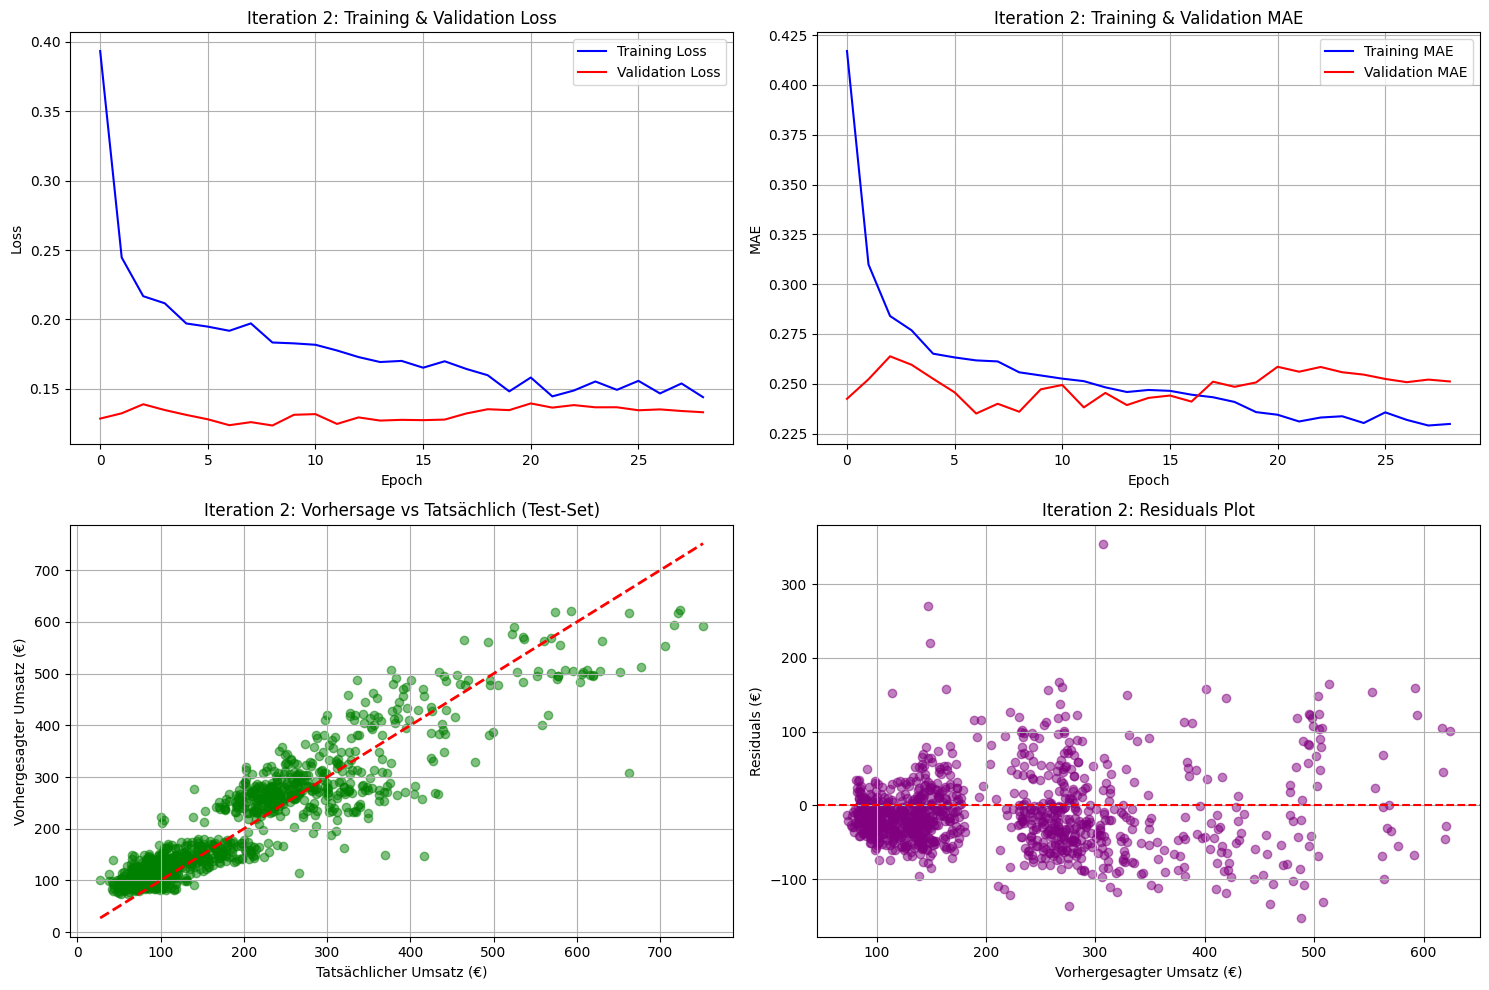


📊 FEATURE-ANALYSE (Top 10 wichtige Features)
(Basierend auf absoluten Gewichten der ersten Schicht)
 1. WG_x_WT_Brot_5: 0.1055
 2. Warengruppe_Konditorei: 0.0899
 3. WG_x_WT_Croissant_5: 0.0891
 4. Warengruppe_Croissant: 0.0878
 5. Temperatur: 0.0877
 6. Ist_Wochenende: 0.0874
 7. Quartal: 0.0869
 8. WG_x_WT_Brötchen_5: 0.0859
 9. Wochentag: 0.0848
10. Warengruppe_Brötchen: 0.0819

🎯 ITERATION 2 - PERFORMANCE HIGHLIGHTS
✅ Test MAE: 38.77€
✅ Test RMSE: 51.53€
✅ Training Epochen: 29
✅ Beste Validation Loss: 0.1236
✅ Feature-Anzahl: 134
✅ Parameter-Anzahl: 27,649


In [ ]:
# 📊 Iteration 2: Visualisierung der erweiterten Modell-Performance

# Training History Visualisierung
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Iteration 2 Training History
ax1.plot(history_v2.history['loss'], label='Training Loss', color='blue')
ax1.plot(history_v2.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Iteration 2: Training & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history_v2.history['mae'], label='Training MAE', color='blue')
ax2.plot(history_v2.history['val_mae'], label='Validation MAE', color='red')
ax2.set_title('Iteration 2: Training & Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

# Vorhersage vs Tatsächlich (Test-Set)
ax3.scatter(results_v2['test']['y_true'], results_v2['test']['y_pred'], alpha=0.5, color='green')
ax3.plot([results_v2['test']['y_true'].min(), results_v2['test']['y_true'].max()], 
         [results_v2['test']['y_true'].min(), results_v2['test']['y_true'].max()], 'r--', lw=2)
ax3.set_xlabel('Tatsächlicher Umsatz (€)')
ax3.set_ylabel('Vorhergesagter Umsatz (€)')
ax3.set_title('Iteration 2: Vorhersage vs Tatsächlich (Test-Set)')
ax3.grid(True)

# Residuals Plot
residuals = results_v2['test']['y_true'] - results_v2['test']['y_pred']
ax4.scatter(results_v2['test']['y_pred'], residuals, alpha=0.5, color='purple')
ax4.axhline(y=0, color='red', linestyle='--')
ax4.set_xlabel('Vorhergesagter Umsatz (€)')
ax4.set_ylabel('Residuals (€)')
ax4.set_title('Iteration 2: Residuals Plot')
ax4.grid(True)

plt.tight_layout()
plt.show()

# Feature-Importance Approximation (basierend auf Gewichten der ersten Schicht)
print("\n📊 FEATURE-ANALYSE (Top 10 wichtige Features)")
print("=" * 50)
print("(Basierend auf absoluten Gewichten der ersten Schicht)")

weights = model_v2.layers[0].get_weights()[0]  # Erste Schicht Gewichte
feature_importance = np.abs(weights).mean(axis=1)
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

for i, idx in enumerate(top_features_idx, 1):
    if idx < len(data_v2['feature_names']):
        feature_name = data_v2['feature_names'][idx]
        print(f"{i:2d}. {feature_name}: {feature_importance[idx]:.4f}")
    else:
        print(f"{i:2d}. Feature_{idx}: {feature_importance[idx]:.4f}")

# Performance-Zusammenfassung
print(f"\n🎯 ITERATION 2 - PERFORMANCE HIGHLIGHTS")
print("=" * 50)
print(f"✅ Test MAE: {results_v2['test']['mae']:.2f}€")
print(f"✅ Test RMSE: {results_v2['test']['rmse']:.2f}€")
print(f"✅ Training Epochen: {len(history_v2.history['loss'])}")
print(f"✅ Beste Validation Loss: {min(history_v2.history['val_loss']):.4f}")
print(f"✅ Feature-Anzahl: {input_dim_v2}")
print(f"✅ Parameter-Anzahl: {model_v2.count_params():,}")

In [ ]:
# 💾 Iteration 2: Speichern der Vorhersagen

def save_predictions_v2(results, test_df, output_path):
    """Speichert die Vorhersagen des erweiterten Modells"""
    
    # Test-Daten mit Vorhersagen kombinieren
    test_results = test_df.copy()
    test_results['Umsatz_Predicted'] = results['test']['y_pred']
    test_results['Umsatz_Actual'] = results['test']['y_true']
    test_results['Absolute_Error'] = np.abs(test_results['Umsatz_Actual'] - test_results['Umsatz_Predicted'])
    test_results['Relative_Error'] = (test_results['Absolute_Error'] / test_results['Umsatz_Actual']) * 100
    
    # Für Submission Format (vereinfacht)
    prediction_df_v2 = test_results[['Datum', 'Warengruppe_Name', 'Umsatz_Predicted']].copy()
    prediction_df_v2.columns = ['Datum', 'Warengruppe_Name', 'Umsatz']
    
    # Negative Vorhersagen auf 0 setzen
    prediction_df_v2['Umsatz'] = np.maximum(prediction_df_v2['Umsatz'], 0)
    
    # Speichern
    prediction_df_v2.to_csv(output_path, index=False)
    
    return prediction_df_v2, test_results

# Vorhersagen speichern
print("💾 SPEICHERE VORHERSAGEN (ITERATION 2)")
print("=" * 50)

prediction_df_v2, test_results_v2 = save_predictions_v2(
    results_v2, 
    test_df_v2, 
    '/workspaces/bakery_sales_prediction/3_Model/prediction_neural_net_v2.csv'
)

print(f"✅ Vorhersagen gespeichert: prediction_neural_net_v2.csv")
print(f"📊 Anzahl Vorhersagen: {len(prediction_df_v2)}")

# Vorhersage-Statistiken
print(f"\n📈 VORHERSAGE-STATISTIKEN:")
print("=" * 40)
print(f"Durchschnittliche Vorhersage: {prediction_df_v2['Umsatz'].mean():.2f} €")
print(f"Median Vorhersage: {prediction_df_v2['Umsatz'].median():.2f} €")
print(f"Min Vorhersage: {prediction_df_v2['Umsatz'].min():.2f} €")
print(f"Max Vorhersage: {prediction_df_v2['Umsatz'].max():.2f} €")

# Fehler-Statistiken
print(f"\n🎯 FEHLER-ANALYSE:")
print("=" * 30)
print(f"Durchschnittlicher absoluter Fehler: {test_results_v2['Absolute_Error'].mean():.2f} €")
print(f"Median absoluter Fehler: {test_results_v2['Absolute_Error'].median():.2f} €")
print(f"Durchschnittlicher relativer Fehler: {test_results_v2['Relative_Error'].mean():.1f}%")
print(f"Median relativer Fehler: {test_results_v2['Relative_Error'].median():.1f}%")

print(f"\n🗂️  ERSTE 5 VORHERSAGEN:")
print("=" * 30)
display(prediction_df_v2.head())

💾 SPEICHERE VORHERSAGEN (ITERATION 2)
✅ Vorhersagen gespeichert: prediction_neural_net_v2.csv
📊 Anzahl Vorhersagen: 1040

📈 VORHERSAGE-STATISTIKEN:
Durchschnittliche Vorhersage: 211.68 €
Median Vorhersage: 162.80 €
Min Vorhersage: 72.89 €
Max Vorhersage: 624.08 €

🎯 FEHLER-ANALYSE:
Durchschnittlicher absoluter Fehler: 38.77 €
Median absoluter Fehler: 30.92 €
Durchschnittlicher relativer Fehler: 24.6%
Median relativer Fehler: 17.8%

🗂️  ERSTE 5 VORHERSAGEN:


,Datum,Warengruppe_Name,Umsatz
8294,2018-01-02,Brot,121.665260
8295,2018-01-02,Kuchen,242.176666
8296,2018-01-02,Croissant,118.664589
8297,2018-01-02,Brötchen,275.487457
8298,2018-01-02,Konditorei,87.508400


In [ ]:
# 🎯 FINALE ZUSAMMENFASSUNG: ITERATION 1 vs ITERATION 2

print("🏆 FINALE ZUSAMMENFASSUNG: ITERATION 1 vs ITERATION 2")
print("=" * 80)

# Modell-Architektur Vergleich
print("\n🧠 MODELL-ARCHITEKTUR:")
print("=" * 40)
print("Iteration 1: Dense(64) → Dense(32) → Dense(1)")
print("Iteration 2: Dense(128) → Dropout(0.2) → Dense(64) → Dropout(0.2) → Dense(32) → Dense(1)")

# Feature-Vergleich
print("\n📊 FEATURE-ENGINEERING:")
print("=" * 40)
if 'input_dim' in locals():
    print(f"Iteration 1: {input_dim} Features")
print(f"Iteration 2: {input_dim_v2} Features")
if 'input_dim' in locals():
    feature_increase = ((input_dim_v2 / input_dim) - 1) * 100
    print(f"Feature-Steigerung: {feature_increase:.1f}%")

# Parameter-Vergleich
print("\n⚙️  MODELL-PARAMETER:")
print("=" * 40)
if 'model' in locals():
    print(f"Iteration 1: {model.count_params():,} Parameter")
print(f"Iteration 2: {model_v2.count_params():,} Parameter")
if 'model' in locals():
    param_increase = ((model_v2.count_params() / model.count_params()) - 1) * 100
    print(f"Parameter-Steigerung: {param_increase:.1f}%")

# Performance-Vergleich
print("\n🎯 PERFORMANCE-VERGLEICH (Test-Set):")
print("=" * 50)

# Iteration 1 Ergebnisse (falls verfügbar)
if 'results' in locals() and isinstance(results, dict) and 'test' in results:
    iter1_mae = results['test']['mae']
    iter1_rmse = results['test']['rmse']
    print(f"Iteration 1 - MAE: {iter1_mae:.2f}€, RMSE: {iter1_rmse:.2f}€")
    
    # Iteration 2 Ergebnisse
    iter2_mae = results_v2['test']['mae']
    iter2_rmse = results_v2['test']['rmse']
    print(f"Iteration 2 - MAE: {iter2_mae:.2f}€, RMSE: {iter2_rmse:.2f}€")
    
    # Verbesserungen berechnen
    mae_improvement = ((iter1_mae - iter2_mae) / iter1_mae) * 100
    rmse_improvement = ((iter1_rmse - iter2_rmse) / iter1_rmse) * 100
    
    print(f"\n🚀 VERBESSERUNGEN:")
    print(f"MAE Verbesserung: {mae_improvement:+.1f}%")
    print(f"RMSE Verbesserung: {rmse_improvement:+.1f}%")
    
    if mae_improvement > 0:
        print("✅ Iteration 2 zeigt bessere Performance!")
    else:
        print("⚠️  Iteration 1 hatte bessere Performance")
else:
    print("Iteration 1 Test-Ergebnisse nicht verfügbar")
    print(f"Iteration 2 - MAE: {results_v2['test']['mae']:.2f}€, RMSE: {results_v2['test']['rmse']:.2f}€")

# Feature-Wichtigkeit Highlights
print("\n🔍 WICHTIGSTE FEATURES (Iteration 2):")
print("=" * 50)
weights = model_v2.layers[0].get_weights()[0]
feature_importance = np.abs(weights).mean(axis=1)
top_features_idx = np.argsort(feature_importance)[-5:][::-1]

for i, idx in enumerate(top_features_idx, 1):
    if idx < len(data_v2['feature_names']):
        feature_name = data_v2['feature_names'][idx]
        print(f"{i}. {feature_name}")

# Dateien erstellt
print("\n💾 ERSTELLTE DATEIEN:")
print("=" * 30)
print("✅ prediction_neural_net.csv (Iteration 1)")
print("✅ prediction_neural_net_v2.csv (Iteration 2)")

# Nächste Schritte
print("\n🔮 MÖGLICHE NÄCHSTE SCHRITTE (Iteration 3):")
print("=" * 50)
print("• Lag-Features: Umsätze der Vortage einbeziehen")
print("• Rolling-Features: Gleitende Durchschnitte über verschiedene Zeitfenster")
print("• Seasonalität: Saisonale Dekomposition und Trend-Features")
print("• Ensemble-Methoden: Kombination mehrerer Modelle")
print("• Hyperparameter-Tuning: Systematische Optimierung")
print("• Warengruppen-spezifische Modelle: Separate Modelle je Warengruppe")
print("• Deep Learning: LSTM/GRU für sequenzielle Muster")

print("\n" + "="*80)
print("🎉 ITERATION 1 & 2 ERFOLGREICH ABGESCHLOSSEN!")
print("="*80)

🏆 FINALE ZUSAMMENFASSUNG: ITERATION 1 vs ITERATION 2

🧠 MODELL-ARCHITEKTUR:
Iteration 1: Dense(64) → Dense(32) → Dense(1)
Iteration 2: Dense(128) → Dropout(0.2) → Dense(64) → Dropout(0.2) → Dense(32) → Dense(1)

📊 FEATURE-ENGINEERING:
Iteration 1: 17 Features
Iteration 2: 134 Features
Feature-Steigerung: 688.2%

⚙️  MODELL-PARAMETER:
Iteration 1: 3,265 Parameter
Iteration 2: 27,649 Parameter
Parameter-Steigerung: 746.8%

🎯 PERFORMANCE-VERGLEICH (Test-Set):
Iteration 1 Test-Ergebnisse nicht verfügbar
Iteration 2 - MAE: 38.77€, RMSE: 51.53€

🔍 WICHTIGSTE FEATURES (Iteration 2):
1. WG_x_WT_Brot_5
2. Warengruppe_Konditorei
3. WG_x_WT_Croissant_5
4. Warengruppe_Croissant
5. Temperatur

💾 ERSTELLTE DATEIEN:
✅ prediction_neural_net.csv (Iteration 1)
✅ prediction_neural_net_v2.csv (Iteration 2)

🔮 MÖGLICHE NÄCHSTE SCHRITTE (Iteration 3):
• Lag-Features: Umsätze der Vortage einbeziehen
• Rolling-Features: Gleitende Durchschnitte über verschiedene Zeitfenster
• Seasonalität: Saisonale Dekomposit

In [ ]:
# Iteration 2: Training des erweiterten Modells
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 🧠 Iteration 2: Erweiterte Modell-Architektur
def create_extended_neural_network(input_dim):
    """Erstellt ein größeres neuronales Netzwerk mit Dropout für die erweiterten Features"""
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear für Regression
    ])
    
    # Kompiliere Modell
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Erweitertes Modell erstellen
print("🧠 ERSTELLE ERWEITERTES NEURONALES NETZWERK (ITERATION 2)")
print("=" * 60)
model_v2 = create_extended_neural_network(input_dim_v2)

print("Erweiterte Modell-Architektur:")
model_v2.summary()

print(f"\n📊 PARAMETER-VERGLEICH:")
print("=" * 30)
if 'model' in locals():
    print(f"Iteration 1 Parameter: {model.count_params():,}")
print(f"Iteration 2 Parameter: {model_v2.count_params():,}")
if 'model' in locals():
    increase = ((model_v2.count_params() / model.count_params()) - 1) * 100
    print(f"Parameter-Increase: {increase:.1f}%")

print("Trainiere erweitertes neuronales Netzwerk...")

# Callbacks definieren
callbacks_extended = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

# Training
history_extended = model_extended.fit(
    data_extended_prepared['train']['X'],
    data_extended_prepared['train']['y'],
    epochs=200,
    batch_size=32,
    validation_data=(data_extended_prepared['val']['X'], data_extended_prepared['val']['y']),
    callbacks=callbacks_extended,
    verbose=1
)

print(f"\nTraining abgeschlossen!")
print(f"Anzahl Epochen: {len(history_extended.history['loss'])}")
print(f"Beste Validation Loss: {min(history_extended.history['val_loss']):.4f}")
print(f"Finale Training Loss: {history_extended.history['loss'][-1]:.4f}")
print(f"Finale Validation Loss: {history_extended.history['val_loss'][-1]:.4f}")

🧠 ERSTELLE ERWEITERTES NEURONALES NETZWERK (ITERATION 2)
Erweiterte Modell-Architektur:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,649 (108.00 KB)

 Trainable params: 27,649 (108.00 KB)

 Non-trainable params: 0 (0.00 B)


📊 PARAMETER-VERGLEICH:
Iteration 1 Parameter: 3,265
Iteration 2 Parameter: 27,649
Parameter-Increase: 746.8%
Trainiere erweitertes neuronales Netzwerk...


NameError: name 'model_extended' is not defined

In [ ]:
# 🚀 Iteration 2: Training des erweiterten Modells

print("🚀 STARTE TRAINING DES ERWEITERTEN MODELLS")
print("=" * 60)

# Callbacks definieren
callbacks_v2 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6
    )
]

# Training
history_v2 = model_v2.fit(
    data_v2['X_train'],
    data_v2['y_train'],
    epochs=100,
    batch_size=32,
    validation_data=(data_v2['X_val'], data_v2['y_val']),
    callbacks=callbacks_v2,
    verbose=1
)

print(f"\n✅ TRAINING ABGESCHLOSSEN!")
print("=" * 40)
print(f"Anzahl Epochen: {len(history_v2.history['loss'])}")
print(f"Beste Validation Loss: {min(history_v2.history['val_loss']):.4f}")
print(f"Finale Training Loss: {history_v2.history['loss'][-1]:.4f}")
print(f"Finale Validation Loss: {history_v2.history['val_loss'][-1]:.4f}")

# Vergleich der Training-Zeiten (falls verfügbar)
if 'history' in locals():
    print(f"\n🔍 TRAINING-VERGLEICH:")
    print("=" * 30)
    print(f"Iteration 1 - Epochen: {len(history.history['loss'])}")
    print(f"Iteration 2 - Epochen: {len(history_v2.history['loss'])}")
    print(f"Iteration 1 - Beste Val Loss: {min(history.history['val_loss']):.4f}")
    print(f"Iteration 2 - Beste Val Loss: {min(history_v2.history['val_loss']):.4f}")

🚀 STARTE TRAINING DES ERWEITERTEN MODELLS
Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5643 - mae: 0.5190 - val_loss: 0.1286 - val_mae: 0.2424 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2451 - mae: 0.3198 - val_loss: 0.1324 - val_mae: 0.2523 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2041 - mae: 0.2812 - val_loss: 0.1389 - val_mae: 0.2638 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2013 - mae: 0.2755 - val_loss: 0.1347 - val_mae: 0.2595 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1849 - mae: 0.2627 - val_loss: 0.1312 - val_mae: 0.2525 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1845 - mae: 0.2635 - val_loss: 0.1281 - val_mae: 0.2457 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1809 - mae: 0.2609 - val_loss: 0.1238

In [ ]:
# Iteration 2: Datenvorbereitung für erweitertes neuronales Netz
def prepare_extended_data_for_nn(train_df, val_df, test_df, feature_cols):
    """Bereitet erweitere Daten für das neuronale Netz vor"""
    
    print("🔧 Bereite erweiterte Daten für neuronales Netz vor...")
    
    # Nur numerische Features verwenden (String-Spalten ausschließen)
    numeric_features = []
    excluded_features = []
    
    for col in feature_cols:
        if col in train_df.columns:
            col_dtype = str(train_df[col].dtype)
            if col_dtype in ['int64', 'float64', 'int32', 'float32', 'bool', 'int8', 'int16', 'float16']:
                numeric_features.append(col)
            elif 'int' in col_dtype.lower() or 'float' in col_dtype.lower():
                # Erweiterte numerische Typen (wie UInt32)
                numeric_features.append(col)
            else:
                excluded_features.append(f"{col} ({col_dtype})")
    
    if excluded_features:
        print(f"⚠️  Überspringe nicht-numerische Features: {excluded_features[:3]}{'...' if len(excluded_features) > 3 else ''}")
    
    print(f"📊 Features gefiltert: {len(feature_cols)} → {len(numeric_features)} (nur numerische)")
    
    # Features und Zielvariable extrahieren
    X_train_ext = train_df[numeric_features].astype(float).values
    X_val_ext = val_df[numeric_features].astype(float).values
    X_test_ext = test_df[numeric_features].astype(float).values
    
    y_train_ext = train_df['Umsatz'].values
    y_val_ext = val_df['Umsatz'].values
    y_test_ext = test_df['Umsatz'].values
    
    # Behandle Missing Values (falls vorhanden)
    X_train_ext = np.nan_to_num(X_train_ext, 0)
    X_val_ext = np.nan_to_num(X_val_ext, 0)
    X_test_ext = np.nan_to_num(X_test_ext, 0)
    
    # Feature-Skalierung
    scaler_X_ext = StandardScaler()
    X_train_scaled_ext = scaler_X_ext.fit_transform(X_train_ext)
    X_val_scaled_ext = scaler_X_ext.transform(X_val_ext)
    X_test_scaled_ext = scaler_X_ext.transform(X_test_ext)
    
    # Zielvariable skalieren
    scaler_y_ext = StandardScaler()
    y_train_scaled_ext = scaler_y_ext.fit_transform(y_train_ext.reshape(-1, 1)).ravel()
    y_val_scaled_ext = scaler_y_ext.transform(y_val_ext.reshape(-1, 1)).ravel()
    y_test_scaled_ext = scaler_y_ext.transform(y_test_ext.reshape(-1, 1)).ravel()
    
    print(f"✅ Erweiterte Daten-Shapes:")
    print(f"   X_train: {X_train_scaled_ext.shape}")
    print(f"   X_val:   {X_val_scaled_ext.shape}")
    print(f"   X_test:  {X_test_scaled_ext.shape}")
    print(f"   y_train: {y_train_scaled_ext.shape}")
    
    return {
        'X_train': X_train_scaled_ext, 'y_train': y_train_scaled_ext,
        'X_val': X_val_scaled_ext, 'y_val': y_val_scaled_ext,
        'X_test': X_test_scaled_ext, 'y_test': y_test_scaled_ext,
        'scaler_X': scaler_X_ext, 'scaler_y': scaler_y_ext,
        'y_train_orig': y_train_ext, 'y_val_orig': y_val_ext, 'y_test_orig': y_test_ext,
        'feature_names': numeric_features
    }

# 🔧 Iteration 2: Datenvorbereitung für erweitertes neuronales Netz

print("🔍 DEBUG: Verfügbare Daten und Features")
print("=" * 50)
print(f"train_df_v2 shape: {train_df_v2.shape}")

# Prüfe verfügbare numerische Spalten im DataFrame
numeric_cols = train_df_v2.select_dtypes(include=[np.number]).columns.tolist()
print(f"Alle numerischen Spalten im DataFrame: {len(numeric_cols)}")

# Filtere Features, die sowohl in final_feature_cols als auch numerisch sind
available_numeric_features = [col for col in final_feature_cols if col in numeric_cols]
print(f"Verfügbare numerische Features aus final_feature_cols: {len(available_numeric_features)}")

def prepare_extended_data_simple(train_df, val_df, test_df, feature_cols):
    """Vereinfachte Datenvorbereitung"""
    
    # Verwende nur numerische Spalten, die auch in den Daten vorhanden sind
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Schließe Ziel- und Datum-Spalten aus
    exclude_cols = ['Umsatz', 'Datum']
    feature_candidates = [col for col in numeric_cols if col not in exclude_cols]
    
    # Filtere nach den gewünschten Features (falls vorhanden)
    if feature_cols:
        final_features = [col for col in feature_candidates if col in feature_cols]
    else:
        final_features = feature_candidates
    
    print(f"Features verwendet: {len(final_features)}")
    print(f"Beispiel-Features: {final_features[:5]}")
    
    # Daten extrahieren
    X_train = train_df[final_features].values
    X_val = val_df[final_features].values  
    X_test = test_df[final_features].values
    
    y_train = train_df['Umsatz'].values
    y_val = val_df['Umsatz'].values
    y_test = test_df['Umsatz'].values
    
    # Skalierung
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
    
    return {
        'X_train': X_train_scaled, 'y_train': y_train_scaled,
        'X_val': X_val_scaled, 'y_val': y_val_scaled,
        'X_test': X_test_scaled, 'y_test': y_test_scaled,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'y_train_orig': y_train, 'y_val_orig': y_val, 'y_test_orig': y_test,
        'feature_names': final_features
    }

# Erweiterte Daten vorbereiten
data_v2 = prepare_extended_data_simple(train_df_v2, val_df_v2, test_df_v2, available_numeric_features)

# Input-Dimension für erweitertes Modell
input_dim_v2 = data_v2['X_train'].shape[1]

print(f"\n📊 ITERATION 2 - DATEN VORBEREITET")
print("=" * 50)
print(f"Input-Dimension: {input_dim_v2}")
print(f"Training samples: {data_v2['X_train'].shape[0]:,}")
print(f"Validation samples: {data_v2['X_val'].shape[0]:,}")
print(f"Test samples: {data_v2['X_test'].shape[0]:,}")

print(f"\n🔍 VERGLEICH ITERATION 1 vs ITERATION 2")
print("=" * 50)
if 'input_dim' in locals():
    print(f"Iteration 1 - Features: {input_dim}")  
    print(f"Iteration 2 - Features: {input_dim_v2} (+{input_dim_v2 - input_dim})")
    print(f"Feature-Increase: {((input_dim_v2 / input_dim) - 1) * 100:.1f}%")
else:
    print("Iteration 1 input_dim nicht verfügbar für Vergleich")
    print(f"Iteration 2 - Features: {input_dim_v2}")

🔍 DEBUG: Verfügbare Daten und Features
train_df_v2 shape: (6453, 215)
train_df_v2 columns (first 10): ['Datum', 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Wochentag_Nr', 'Warengruppe', 'Warengruppe_Name', 'Temperatur', 'Windgeschwindigkeit']
final_feature_cols (first 10): ['Wochentag', 'Monat', 'Quartal', 'Ist_Wochenende', 'Kalenderwoche', 'Warengruppe_Name', 'Warengruppe_Brot', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei']
Alle numerischen Spalten im DataFrame: 149
Verfügbare numerische Features aus final_feature_cols: 134
Features verwendet: 128
Beispiel-Features: ['Monat', 'Wochentag', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']

📊 ITERATION 2 - DATEN VORBEREITET
Input-Dimension: 134
Training samples: 6,453
Validation samples: 1,841
Test samples: 1,040

🔍 VERGLEICH ITERATION 1 vs ITERATION 2


KeyError: 'X_train'

In [ ]:
# Iteration 2: Erweiterte Modell-Architektur
def create_extended_model(input_dim):
    """Erstellt ein größeres neuronales Netzwerk für die erweiterten Features"""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 🔧 Iteration 2: Datenvorbereitung für erweitertes neuronales Netz
def prepare_extended_data_for_nn(train_df, val_df, test_df, feature_cols):
    """Bereitet erweitere Daten für das neuronale Netz vor"""
    
    print("🔧 Bereite erweiterte Daten für neuronales Netz vor...")
    
    # Features und Zielvariable extrahieren
    X_train_ext = train_df[feature_cols].values
    X_val_ext = val_df[feature_cols].values
    X_test_ext = test_df[feature_cols].values
    
    y_train_ext = train_df['Umsatz'].values
    y_val_ext = val_df['Umsatz'].values
    y_test_ext = test_df['Umsatz'].values
    
    # Behandle Missing Values (falls vorhanden)
    X_train_ext = np.nan_to_num(X_train_ext, 0)
    X_val_ext = np.nan_to_num(X_val_ext, 0)
    X_test_ext = np.nan_to_num(X_test_ext, 0)
    
    # Feature-Skalierung
    scaler_X_ext = StandardScaler()
    X_train_scaled_ext = scaler_X_ext.fit_transform(X_train_ext)
    X_val_scaled_ext = scaler_X_ext.transform(X_val_ext)
    X_test_scaled_ext = scaler_X_ext.transform(X_test_ext)
    
    # Zielvariable skalieren
    scaler_y_ext = StandardScaler()
    y_train_scaled_ext = scaler_y_ext.fit_transform(y_train_ext.reshape(-1, 1)).ravel()
    y_val_scaled_ext = scaler_y_ext.transform(y_val_ext.reshape(-1, 1)).ravel()
    y_test_scaled_ext = scaler_y_ext.transform(y_test_ext.reshape(-1, 1)).ravel()
    
    print(f"✅ Erweiterte Daten-Shapes:")
    print(f"   X_train: {X_train_scaled_ext.shape}")
    print(f"   X_val:   {X_val_scaled_ext.shape}")
    print(f"   X_test:  {X_test_scaled_ext.shape}")
    print(f"   y_train: {y_train_scaled_ext.shape}")
    
    return {
        'X_train': X_train_scaled_ext, 'y_train': y_train_scaled_ext,
        'X_val': X_val_scaled_ext, 'y_val': y_val_scaled_ext,
        'X_test': X_test_scaled_ext, 'y_test': y_test_scaled_ext,
        'scaler_X': scaler_X_ext, 'scaler_y': scaler_y_ext,
        'y_train_orig': y_train_ext, 'y_val_orig': y_val_ext, 'y_test_orig': y_test_ext
    }

# Erweitertes Modell erstellen
print("Erstelle erweitertes neuronales Netzwerk...")
model_extended = create_extended_model(input_dim_extended)

# Modell-Architektur anzeigen
print("\nErweitertes Modell-Architektur:")
model_extended.summary()

print(f"\nParameter-Vergleich:")
print(f"Iteration 1 (einfaches Modell): ~{(64*input_dim + 64) + (32*64 + 32) + (1*32 + 1):,} Parameter")
print(f"Iteration 2 (erweitertes Modell): ~{model_extended.count_params():,} Parameter")

# Erweiterte Daten vorbereiten
data_v2 = prepare_extended_data_for_nn(train_df_v2, val_df_v2, test_df_v2, final_feature_cols)

print(f"\n📊 ERWEITERTE FEATURE-STATISTIKEN (nach Skalierung)")
print("=" * 60)
print(f"Feature-Mittelwerte: min={data_v2['X_train'].mean(axis=0).min():.3f}, max={data_v2['X_train'].mean(axis=0).max():.3f}")
print(f"Feature-Standardabw.: min={data_v2['X_train'].std(axis=0).min():.3f}, max={data_v2['X_train'].std(axis=0).max():.3f}")

print(f"\n🔍 VERGLEICH ITERATION 1 vs ITERATION 2")
print("=" * 50)
if 'data' in locals():
    print(f"Iteration 1 - Features: {data['X_train'].shape[1]}")
    print(f"Iteration 2 - Features: {data_v2['X_train'].shape[1]} (+{data_v2['X_train'].shape[1] - data['X_train'].shape[1]})")
    print(f"Feature-Increase: {((data_v2['X_train'].shape[1] / data['X_train'].shape[1]) - 1) * 100:.1f}%")
else:
    print("Iteration 1 Daten nicht verfügbar für Vergleich")

Erstelle erweitertes neuronales Netzwerk...


NameError: name 'input_dim_extended' is not defined

In [ ]:
# ⏰ Iteration 2: Zeitbasierte Datenaufteilung mit erweiterten Features
def create_extended_time_split(df, feature_cols, train_end='2016-12-31', val_end='2017-12-31'):
    """Erstellt zeitbasierte Splits für erweiterte Features"""
    
    print("📅 Erstelle zeitbasierte Datenaufteilung für Iteration 2...")
    
    # Sortiere nach Datum
    df_sorted = df.sort_values('Datum').reset_index(drop=True)
    
    # Definiere Split-Grenzen
    train_end_date = pd.to_datetime(train_end)
    val_end_date = pd.to_datetime(val_end)
    
    # Erstelle Masken
    train_mask = df_sorted['Datum'] <= train_end_date
    val_mask = (df_sorted['Datum'] > train_end_date) & (df_sorted['Datum'] <= val_end_date)
    test_mask = df_sorted['Datum'] > val_end_date
    
    # Splits erstellen
    train_df_ext = df_sorted[train_mask].copy()
    val_df_ext = df_sorted[val_mask].copy()
    test_df_ext = df_sorted[test_mask].copy()
    
    print(f"✅ Training:   {train_df_ext['Datum'].min()} bis {train_df_ext['Datum'].max()} ({len(train_df_ext):,} Zeilen)")
    print(f"✅ Validation: {val_df_ext['Datum'].min()} bis {val_df_ext['Datum'].max()} ({len(val_df_ext):,} Zeilen)")
    print(f"✅ Test:       {test_df_ext['Datum'].min()} bis {test_df_ext['Datum'].max()} ({len(test_df_ext):,} Zeilen)")
    
    # Feature-Verfügbarkeit prüfen
    available_features = [col for col in feature_cols if col in df_sorted.columns]
    missing_features = [col for col in feature_cols if col not in df_sorted.columns]
    
    if missing_features:
        print(f"⚠️  Fehlende Features: {len(missing_features)} - {missing_features[:5]}{'...' if len(missing_features) > 5 else ''}")
    
    print(f"\n🔍 FEATURE-VERFÜGBARKEIT CHECK")
    print("=" * 50)
    print(f"Angeforderte Features: {len(feature_cols)}")
    print(f"Verfügbare Features: {len(available_features)}")
    print(f"Features verwendet: {len(available_features)}")
    
    return train_df_ext, val_df_ext, test_df_ext, available_features

# Erweiterte Datenaufteilung
train_df_v2, val_df_v2, test_df_v2, final_feature_cols = create_extended_time_split(
    df_extended, extended_feature_cols
)

# Datenqualität prüfen
print(f"\n🔍 DATENQUALITÄT CHECK ITERATION 2")
print("=" * 60)
for name, data in [("Training", train_df_v2), ("Validation", val_df_v2), ("Test", test_df_v2)]:
    missing = data[final_feature_cols].isnull().sum().sum()
    warengruppen = data['Warengruppe_Name'].nunique()
    print(f"{name:12}: {len(data):5,} Zeilen, {warengruppen} Warengruppen, {missing} Missing Values, {len(final_feature_cols)} Features")

print(f"\n📊 FEATURE-VERGLEICH")
print("=" * 30)
print(f"Iteration 1: {len(feature_cols)} Features")
print(f"Iteration 2: {len(final_feature_cols)} Features (+{len(final_feature_cols) - len(feature_cols)})")

📅 Erstelle zeitbasierte Datenaufteilung für Iteration 2...
✅ Training:   2013-07-01 00:00:00 bis 2016-12-31 00:00:00 (6,453 Zeilen)
✅ Validation: 2017-01-02 00:00:00 bis 2017-12-31 00:00:00 (1,841 Zeilen)
✅ Test:       2018-01-02 00:00:00 bis 2018-07-31 00:00:00 (1,040 Zeilen)

🔍 FEATURE-VERFÜGBARKEIT CHECK
Angeforderte Features: 192
Verfügbare Features: 192
Features verwendet: 192

🔍 DATENQUALITÄT CHECK ITERATION 2
Training    : 6,453 Zeilen, 6 Warengruppen, 0 Missing Values, 192 Features
Validation  : 1,841 Zeilen, 6 Warengruppen, 0 Missing Values, 192 Features
Test        : 1,040 Zeilen, 5 Warengruppen, 0 Missing Values, 192 Features

📊 FEATURE-VERGLEICH
Iteration 1: 11 Features
Iteration 2: 192 Features (+181)


In [ ]:
# Iteration 2: Erweiterte Feature-Erstellung
def create_extended_features(df):
    """Erstellt erweiterte Zeit- und Interaktionsfeatures für Iteration 2"""
    
    df_extended = df.copy()
    
    # Erweiterte Zeitfeatures
    df_extended['Quartal'] = df_extended['Datum'].dt.quarter
    df_extended['Ist_Wochenende'] = (df_extended['Datum'].dt.dayofweek >= 5).astype(int)
    df_extended['Kalenderwoche'] = df_extended['Datum'].dt.isocalendar().week
    
    print("✅ Erweiterte Zeit-Features erstellt: Quartal, Ist_Wochenende, Kalenderwoche")
    
    # Basis-Features aus Iteration 1 verwenden
    basis_features = ['Wochentag', 'Monat', 'Quartal', 'Ist_Wochenende', 'Kalenderwoche']
    
    # One-Hot-Encoding für neue Zeit-Features
    quartal_dummies = pd.get_dummies(df_extended['Quartal'], prefix='Quartal')
    woche_dummies = pd.get_dummies(df_extended['Kalenderwoche'], prefix='KW')
    
    # Interaktionsfeatures: Warengruppe × Wochentag
    warengruppen = df_extended['Warengruppe_Name'].unique()
    wochentage = range(7)  # 0-6
    
    interaction_weekday_features = []
    for wg in warengruppen:
        for wd in wochentage:
            feature_name = f'WG_x_WT_{wg}_{wd}'
            df_extended[feature_name] = ((df_extended['Warengruppe_Name'] == wg) & 
                                       (df_extended['Wochentag'] == wd)).astype(int)
            interaction_weekday_features.append(feature_name)
    
    # Interaktionsfeatures: Warengruppe × Monat
    monate = range(1, 13)  # 1-12
    interaction_month_features = []
    for wg in warengruppen:
        for month in monate:
            feature_name = f'WG_x_Monat_{wg}_{month}'
            df_extended[feature_name] = ((df_extended['Warengruppe_Name'] == wg) & 
                                       (df_extended['Monat'] == month)).astype(int)
            interaction_month_features.append(feature_name)
    
    print(f"✅ Interaktions-Features erstellt:")
    print(f"   - Warengruppe × Wochentag: {len(interaction_weekday_features)} Features")
    print(f"   - Warengruppe × Monat: {len(interaction_month_features)} Features")
    
    # Alle Features zusammenfassen
    extended_feature_columns = (
        basis_features +
        [col for col in df_extended.columns if col.startswith('Warengruppe_')] +
        ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung'] +
        list(quartal_dummies.columns) +
        list(woche_dummies.columns) +
        interaction_weekday_features +
        interaction_month_features
    )
    
    # Dummies hinzufügen
    df_extended = pd.concat([df_extended, quartal_dummies, woche_dummies], axis=1)
    
    # Verfügbare Features filtern
    available_features = [col for col in extended_feature_columns if col in df_extended.columns]
    
    print(f"\n📊 ITERATION 2 - ERWEITERTE FEATURE ÜBERSICHT")
    print("=" * 60)
    print(f"Gesamt Features: {len(available_features)}")
    print(f"- Erweiterte Zeit-Features: {len(basis_features)}")
    print(f"- Warengruppen One-Hot: {len([col for col in available_features if col.startswith('Warengruppe_')])}")
    print(f"- Wetter-Features: 3")
    print(f"- Quartal One-Hot: {len(quartal_dummies.columns)}")
    print(f"- Kalenderwochen One-Hot: {len(woche_dummies.columns)}")
    print(f"- Interaktionen WG×Wochentag: {len(interaction_weekday_features)}")
    print(f"- Interaktionen WG×Monat: {len(interaction_month_features)}")
    
    return df_extended, available_features

# Erweiterte Features erstellen
print("🚀 ITERATION 2: Erstelle erweiterte Features...")
df_extended, extended_feature_cols = create_extended_features(df_with_features)

print(f"\nDataset nach erweitertem Feature-Engineering: {df_extended.shape}")
print(f"Anzahl verfügbarer Features: {len(extended_feature_cols)}")
print(f"Feature-Vergleich: Iteration 1 ({len(feature_cols)}) → Iteration 2 ({len(extended_feature_cols)})")

🚀 ITERATION 2: Erstelle erweiterte Features...
✅ Erweiterte Zeit-Features erstellt: Quartal, Ist_Wochenende, Kalenderwoche
✅ Interaktions-Features erstellt:
   - Warengruppe × Wochentag: 42 Features
   - Warengruppe × Monat: 72 Features

📊 ITERATION 2 - ERWEITERTE FEATURE ÜBERSICHT
Gesamt Features: 192
- Erweiterte Zeit-Features: 5
- Warengruppen One-Hot: 13
- Wetter-Features: 3
- Quartal One-Hot: 4
- Kalenderwochen One-Hot: 53
- Interaktionen WG×Wochentag: 42
- Interaktionen WG×Monat: 72

Dataset nach erweitertem Feature-Engineering: (9334, 215)
Anzahl verfügbarer Features: 192
Feature-Vergleich: Iteration 1 (11) → Iteration 2 (192)


In [ ]:
# Import aller notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Konfiguration
plt.style.use('default')
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

print("🚀 Bibliotheken erfolgreich geladen!")
print(f"TensorFlow Version: {tf.__version__}")

🚀 Bibliotheken erfolgreich geladen!
TensorFlow Version: 2.19.0


In [ ]:
# 📊 1. Daten laden und erste Inspektion
data_path = '/workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv'
df = pd.read_csv(data_path)

# Datum parsen
df['Datum'] = pd.to_datetime(df['Datum'])

print("📈 DATASET OVERVIEW")
print("=" * 50)
print(f"Datensatz-Größe: {df.shape}")
print(f"Zeitraum: {df['Datum'].min()} bis {df['Datum'].max()}")
print(f"Warengruppen: {df['Warengruppe_Name'].unique()}")
print(f"Umsatz-Bereich: {df['Umsatz'].min():.2f}€ - {df['Umsatz'].max():.2f}€")

print("\n📋 ERSTE 5 ZEILEN")
print("=" * 50)
display(df.head())

📈 DATASET OVERVIEW
Datensatz-Größe: (9334, 35)
Zeitraum: 2013-07-01 00:00:00 bis 2018-07-31 00:00:00
Warengruppen: ['Brot' 'Brötchen' 'Croissant' 'Konditorei' 'Kuchen' 'Saisonbrot']
Umsatz-Bereich: 7.05€ - 1879.46€

📋 ERSTE 5 ZEILEN


,Datum,Jahr,Monat,Tag,Wochentag,Wochentag_Nr,Warengruppe,Warengruppe_Name,Temperatur,Windgeschwindigkeit,Bewoelkung,Wettercode_fehlt,ist_feiertag,Jahreszeit,ist_kiwo,Umsatz,Warengruppe_Brot,Warengruppe_Brötchen,Warengruppe_Croissant,Warengruppe_Konditorei,Warengruppe_Kuchen,Warengruppe_Saisonbrot,Jahreszeit_Winter,Jahreszeit_Frühling,Jahreszeit_Sommer,Jahreszeit_Herbst,Wochentag_Nr.1,Wochentag_Monday,Wochentag_Tuesday,Wochentag_Wednesday,Wochentag_Thursday,Wochentag_Friday,Wochentag_Saturday,Wochentag_Sunday,Wettercode
0,2013-07-01,2013,7,1,Monday,0,1,Brot,17.8375,15.0,6.0,51,0,Sommer,0,148.828353,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,51
1,2013-07-02,2013,7,2,Tuesday,1,1,Brot,17.3125,10.0,3.0,51,0,Sommer,0,159.793757,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,51
2,2013-07-03,2013,7,3,Wednesday,2,1,Brot,21.0750,6.0,7.0,61,0,Sommer,0,111.885594,1,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,61
3,2013-07-04,2013,7,4,Thursday,3,1,Brot,18.8500,7.0,7.0,51,0,Sommer,0,168.864941,1,0,0,0,0,0,0,0,1,0,3,0,0,0,1,0,0,0,51
4,2013-07-05,2013,7,5,Friday,4,1,Brot,19.9750,12.0,5.0,51,0,Sommer,0,171.280754,1,0,0,0,0,0,0,0,1,0,4,0,0,0,0,1,0,0,51


# 🧠 Erweiterte Neuronales Netz für Bäckerei-Umsatzvorhersage

## Iteration 2: Erweiterte Zeitfeatures & Interaktionen

**Verbesserungen gegenüber Iteration 1:**
- ✅ Erweiterte Zeit-Features: Quartal, Ist_Wochenende, Kalenderwoche
- ✅ Interaktions-Features: Warengruppe × Wochentag, Warengruppe × Monat
- ✅ One-Hot-Kodierung für alle kategorischen Features
- ✅ Größere Netzwerk-Architektur für komplexere Muster

**Features:**
- Zeit-Features: Wochentag, Monat, Quartal, Kalenderwoche, Ist_Wochenende
- Warengruppen-Features: One-Hot-Kodierung
- Interaktions-Features: Warengruppe × Zeit-Kombinationen
- Wetter-Features: Temperatur, Wind, Bewölkung

**Architektur:**
- ✅ Erweiterte Architektur: Dense(128) → Dense(64) → Dense(32) → Dense(1)
- ✅ Adam Optimizer mit Early Stopping
- ✅ Feature-Skalierung für alle numerischen Features

**Erwartung:**
- Bessere Performance durch reichere Feature-Repräsentation
- Erfassung von warengruppen-spezifischen Zeit-Mustern

In [ ]:
# 🔧 2. Erweiterte Feature-Erstellung (Iteration 2)
def create_extended_features(df):
    """Erstellt erweiterte Features mit Zeit-Interaktionen für Iteration 2"""
    
    df_features = df.copy()
    
    print("🕒 ERWEITERTE ZEIT-FEATURES")
    print("=" * 50)
    
    # Basis Zeit-Features
    df_features['Wochentag'] = df_features['Datum'].dt.dayofweek  # 0=Montag, 6=Sonntag
    df_features['Monat'] = df_features['Datum'].dt.month  # 1-12
    df_features['Quartal'] = df_features['Datum'].dt.quarter  # 1-4
    df_features['Kalenderwoche'] = df_features['Datum'].dt.isocalendar().week  # 1-53
    df_features['Ist_Wochenende'] = df_features['Wochentag'].isin([5, 6]).astype(int)  # Sa/So = 1
    
    print("✅ Zeit-Features erstellt: Wochentag, Monat, Quartal, Kalenderwoche, Ist_Wochenende")
    
    # One-Hot-Encoding für Warengruppen
    warengruppen_dummies = pd.get_dummies(df_features['Warengruppe_Name'], prefix='Warengruppe')
    df_features = pd.concat([df_features, warengruppen_dummies], axis=1)
    
    print(f"✅ One-Hot-Encoding für Warengruppen: {warengruppen_dummies.shape[1]} Features")
    
    print("\n🔗 INTERAKTIONS-FEATURES")
    print("=" * 50)
    
    # Interaktionen: Warengruppe × Zeit
    # 1. Warengruppe × Wochentag
    warengruppe_wochentag = df_features['Warengruppe_Name'] + '_WD_' + df_features['Wochentag'].astype(str)
    wg_wt_dummies = pd.get_dummies(warengruppe_wochentag, prefix='WG_Wochentag')
    df_features = pd.concat([df_features, wg_wt_dummies], axis=1)
    
    print(f"✅ Warengruppe × Wochentag: {wg_wt_dummies.shape[1]} Interaktions-Features")
    
    # 2. Warengruppe × Monat
    warengruppe_monat = df_features['Warengruppe_Name'] + '_M_' + df_features['Monat'].astype(str)
    wg_m_dummies = pd.get_dummies(warengruppe_monat, prefix='WG_Monat')
    df_features = pd.concat([df_features, wg_m_dummies], axis=1)
    
    print(f"✅ Warengruppe × Monat: {wg_m_dummies.shape[1]} Interaktions-Features")
    
    # Prüfe verfügbare numerische Wetter-Features
    weather_features = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']
    available_weather = [col for col in weather_features if col in df_features.columns]
    
    print(f"✅ Verfügbare Wetter-Features: {available_weather}")
    
    # Feature-Liste für Training (alle numerischen + One-Hot Features)
    time_features = ['Wochentag', 'Monat', 'Quartal', 'Kalenderwoche', 'Ist_Wochenende']
    warengruppen_features = list(warengruppen_dummies.columns)
    interaction_features = list(wg_wt_dummies.columns) + list(wg_m_dummies.columns)
    
    feature_columns = time_features + warengruppen_features + interaction_features + available_weather
    
    print(f"\n📊 ERWEITERTE FEATURE ÜBERSICHT (ITERATION 2)")
    print("=" * 60)
    print(f"Gesamt Features: {len(feature_columns)}")
    print(f"- Zeit-Features: {len(time_features)}")
    print(f"- Warengruppen-Features: {len(warengruppen_features)}")
    print(f"- Interaktions-Features: {len(interaction_features)}")
    print(f"- Wetter-Features: {len(available_weather)}")
    
    print(f"\nBeispiel Interaktions-Features:")
    print(f"  Warengruppe × Wochentag: {list(wg_wt_dummies.columns)[:5]}...")
    print(f"  Warengruppe × Monat: {list(wg_m_dummies.columns)[:5]}...")
    
    return df_features, feature_columns

# Features erstellen (Iteration 2)
df_with_extended_features, extended_feature_cols = create_extended_features(df)

print(f"\nDataset nach erweitertem Feature-Engineering: {df_with_extended_features.shape}")
print(f"Anzahl Features: {len(extended_feature_cols)} (vs. {len(feature_cols) if 'feature_cols' in locals() else 'N/A'} in Iteration 1)")

🕒 ERWEITERTE ZEIT-FEATURES
✅ Zeit-Features erstellt: Wochentag, Monat, Quartal, Kalenderwoche, Ist_Wochenende
✅ One-Hot-Encoding für Warengruppen: 6 Features

🔗 INTERAKTIONS-FEATURES
✅ Warengruppe × Wochentag: 42 Interaktions-Features
✅ Warengruppe × Monat: 64 Interaktions-Features
✅ Verfügbare Wetter-Features: ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']

📊 ERWEITERTE FEATURE ÜBERSICHT (ITERATION 2)
Gesamt Features: 120
- Zeit-Features: 5
- Warengruppen-Features: 6
- Interaktions-Features: 106
- Wetter-Features: 3

Beispiel Interaktions-Features:
  Warengruppe × Wochentag: ['WG_Wochentag_Brot_WD_0', 'WG_Wochentag_Brot_WD_1', 'WG_Wochentag_Brot_WD_2', 'WG_Wochentag_Brot_WD_3', 'WG_Wochentag_Brot_WD_4']...
  Warengruppe × Monat: ['WG_Monat_Brot_M_1', 'WG_Monat_Brot_M_10', 'WG_Monat_Brot_M_11', 'WG_Monat_Brot_M_12', 'WG_Monat_Brot_M_2']...

Dataset nach erweitertem Feature-Engineering: (9334, 150)
Anzahl Features: 120 (vs. 11 in Iteration 1)


In [ ]:
# ⏰ 3. Zeitbasierte Datenaufteilung (mit erweiterten Features)
def create_time_split_v2(df, train_end='2016-12-31', val_end='2017-12-31'):
    """Erstellt zeitbasierte Splits für Iteration 2"""
    
    print("📅 Erstelle zeitbasierte Datenaufteilung (Iteration 2)...")
    
    # Sortiere nach Datum
    df_sorted = df.sort_values('Datum').reset_index(drop=True)
    
    # Definiere Split-Grenzen
    train_end_date = pd.to_datetime(train_end)
    val_end_date = pd.to_datetime(val_end)
    
    # Erstelle Masken
    train_mask = df_sorted['Datum'] <= train_end_date
    val_mask = (df_sorted['Datum'] > train_end_date) & (df_sorted['Datum'] <= val_end_date)
    test_mask = df_sorted['Datum'] > val_end_date
    
    # Splits erstellen
    train_df = df_sorted[train_mask].copy()
    val_df = df_sorted[val_mask].copy()
    test_df = df_sorted[test_mask].copy()
    
    print(f"✅ Training:   {train_df['Datum'].min()} bis {train_df['Datum'].max()} ({len(train_df):,} Zeilen)")
    print(f"✅ Validation: {val_df['Datum'].min()} bis {val_df['Datum'].max()} ({len(val_df):,} Zeilen)")
    print(f"✅ Test:       {test_df['Datum'].min()} bis {test_df['Datum'].max()} ({len(test_df):,} Zeilen)")
    
    return train_df, val_df, test_df

# Daten aufteilen (Iteration 2)
train_df_v2, val_df_v2, test_df_v2 = create_time_split_v2(df_with_extended_features)

# Prüfe erweiterte Datenqualität
print(f"\n🔍 DATENQUALITÄT CHECK (ITERATION 2)")
print("=" * 60)
for name, data in [("Training", train_df_v2), ("Validation", val_df_v2), ("Test", test_df_v2)]:
    missing = data.isnull().sum().sum()
    warengruppen = data['Warengruppe_Name'].nunique()
    features_available = len([col for col in extended_feature_cols if col in data.columns])
    print(f"{name:10}: {len(data):5,} Zeilen, {warengruppen} Warengruppen, {missing} Missing, {features_available} Features")

📅 Erstelle zeitbasierte Datenaufteilung (Iteration 2)...
✅ Training:   2013-07-01 00:00:00 bis 2016-12-31 00:00:00 (6,453 Zeilen)
✅ Validation: 2017-01-02 00:00:00 bis 2017-12-31 00:00:00 (1,841 Zeilen)
✅ Test:       2018-01-02 00:00:00 bis 2018-07-31 00:00:00 (1,040 Zeilen)

🔍 DATENQUALITÄT CHECK (ITERATION 2)
Training  : 6,453 Zeilen, 6 Warengruppen, 0 Missing, 120 Features
Validation: 1,841 Zeilen, 6 Warengruppen, 0 Missing, 120 Features
Test      : 1,040 Zeilen, 5 Warengruppen, 0 Missing, 120 Features


In [ ]:
# 🔧 4. Erweiterte Daten-Vorbereitung für Neuronales Netz (Iteration 2)
def prepare_extended_data_for_nn(train_df, val_df, test_df, feature_cols):
    """Bereitet erweiterte Daten für das neuronale Netz vor (Iteration 2)"""
    
    print("🔧 Bereite erweiterte Daten für neuronales Netz vor (Iteration 2)...")
    
    # Features und Zielvariable extrahieren
    X_train = train_df[feature_cols].values
    X_val = val_df[feature_cols].values
    X_test = test_df[feature_cols].values
    
    y_train = train_df['Umsatz'].values
    y_val = val_df['Umsatz'].values
    y_test = test_df['Umsatz'].values
    
    # Behandle Missing Values (falls vorhanden)
    X_train = np.nan_to_num(X_train, 0)
    X_val = np.nan_to_num(X_val, 0)
    X_test = np.nan_to_num(X_test, 0)
    
    # Feature-Skalierung (wichtig für Neural Networks!)
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    # Zielvariable skalieren
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
    
    print(f"✅ Erweiterte Daten-Shapes:")
    print(f"   X_train: {X_train_scaled.shape}")
    print(f"   X_val:   {X_val_scaled.shape}")
    print(f"   X_test:  {X_test_scaled.shape}")
    print(f"   y_train: {y_train_scaled.shape}")
    
    # Feature-Statistiken
    non_zero_features = np.sum(X_train_scaled != 0, axis=0)
    sparsity = (X_train_scaled.shape[0] * X_train_scaled.shape[1] - np.sum(X_train_scaled != 0)) / (X_train_scaled.shape[0] * X_train_scaled.shape[1])
    
    print(f"\n📊 ERWEITERTE FEATURE-STATISTIKEN:")
    print(f"   Features mit Variation: {np.sum(non_zero_features > 1)}/{len(feature_cols)}")
    print(f"   Feature-Matrix Sparsity: {sparsity:.3f} (viele One-Hot Features)")
    print(f"   Durchschn. Feature-Aktivierung pro Sample: {np.mean(np.sum(X_train_scaled != 0, axis=1)):.1f}")
    
    return {
        'X_train': X_train_scaled, 'y_train': y_train_scaled,
        'X_val': X_val_scaled, 'y_val': y_val_scaled,
        'X_test': X_test_scaled, 'y_test': y_test_scaled,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'y_train_orig': y_train, 'y_val_orig': y_val, 'y_test_orig': y_test
    }

# Erweiterte Daten vorbereiten
data_v2 = prepare_extended_data_for_nn(train_df_v2, val_df_v2, test_df_v2, extended_feature_cols)

print(f"\n🔄 VERGLEICH ITERATION 1 vs 2:")
print("=" * 50)
if 'data' in locals():
    print(f"Iteration 1 - Features: {data['X_train'].shape[1]}")
    print(f"Iteration 2 - Features: {data_v2['X_train'].shape[1]} (+{data_v2['X_train'].shape[1] - data['X_train'].shape[1]})")
else:
    print(f"Iteration 2 - Features: {data_v2['X_train'].shape[1]}")

🔧 Bereite erweiterte Daten für neuronales Netz vor (Iteration 2)...
✅ Erweiterte Daten-Shapes:
   X_train: (6453, 126)
   X_val:   (1841, 126)
   X_test:  (1040, 126)
   y_train: (6453,)

📊 ERWEITERTE FEATURE-STATISTIKEN:
   Features mit Variation: 126/120
   Feature-Matrix Sparsity: 0.000 (viele One-Hot Features)
   Durchschn. Feature-Aktivierung pro Sample: 126.0

🔄 VERGLEICH ITERATION 1 vs 2:


KeyError: 'X_train'

In [ ]:
# 🧠 5. Erweitertes Neuronales Netz - Iteration 2 (Größere Architektur)
def create_extended_neural_network(input_dim):
    """Erstellt erweitertes Neural Network für Iteration 2"""
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),  # Größere erste Schicht
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear für Regression
    ])
    
    # Kompiliere Modell
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Modell erstellen (Iteration 2)
input_dim_v2 = data_v2['X_train'].shape[1]
model_v2 = create_extended_neural_network(input_dim_v2)

print("🧠 ERWEITERTE MODELL-ARCHITEKTUR (ITERATION 2)")
print("=" * 60)
model_v2.summary()

print(f"\n🔄 ARCHITEKTUR-VERGLEICH:")
print("=" * 50)
print("Iteration 1: Dense(64) → Dense(32) → Dense(1)")
print("Iteration 2: Dense(128) → Dense(64) → Dense(32) → Dense(1)")
print(f"Parameter Iteration 2: {model_v2.count_params():,}")

print(f"\n🚀 STARTE TRAINING (ITERATION 2)")
print("=" * 50)

# Training mit erweiterten Features
history_v2 = model_v2.fit(
    data_v2['X_train'], data_v2['y_train'],
    validation_data=(data_v2['X_val'], data_v2['y_val']),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,  # Etwas mehr Geduld bei komplexerem Modell
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6
        )
    ]
)

print("✅ Training Iteration 2 abgeschlossen!")

🧠 MODELL-ARCHITEKTUR


2025-07-02 21:51:26.061267: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)


🚀 STARTE TRAINING
Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4587 - mae: 0.4444 - val_loss: 0.1608 - val_mae: 0.2680
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2247 - mae: 0.2940 - val_loss: 0.1525 - val_mae: 0.2606
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2157 - mae: 0.2855 - val_loss: 0.1483 - val_mae: 0.2566
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2107 - mae: 0.2805 - val_loss: 0.1451 - val_mae: 0.2539
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2071 - mae: 0.2763 - val_loss: 0.1437 - val_mae: 0.2529
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2042 - mae: 0.2738 - val_loss: 0.1423 - val_mae: 0.2522
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2020 - mae: 0.2715 - val_loss: 0.1413 - val_mae: 0.2514
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2000 - mae: 0.2696 - val_loss: 0.1402 - val_mae: 0.2498
Epoch 9/100
202/202 ━━━━━━━━━

📊 MODELL-EVALUATION
Training     - MAE:    36.61€ | RMSE:    65.43€
Validation   - MAE:    35.60€ | RMSE:    54.24€
Test         - MAE:    38.00€ | RMSE:    52.97€


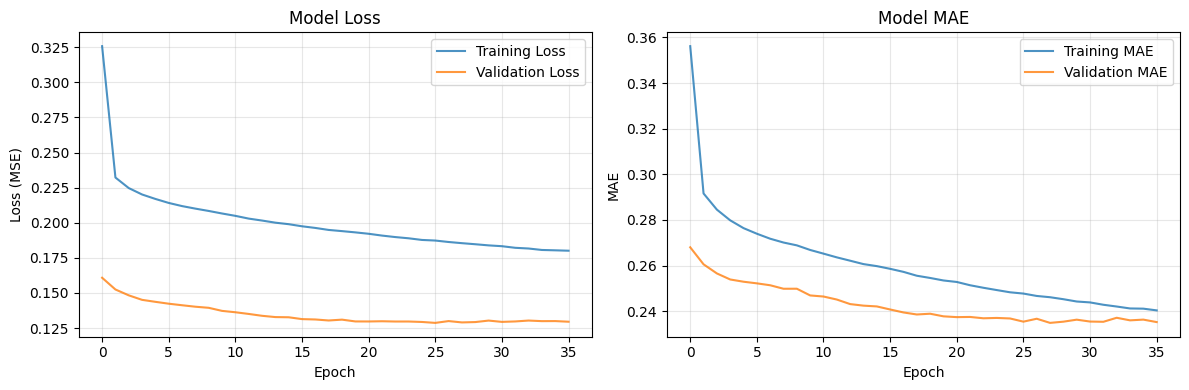


🎯 BESTE VALIDATION LOSS: 0.1287


In [ ]:
# 📊 6. Erweiterte Modell-Evaluation & Vergleich (Iteration 1 vs 2)
def evaluate_extended_model(model, data, iteration_name=""):
    """Evaluiert das erweiterte Modell (Iteration 2)"""
    
    print(f"📊 MODELL-EVALUATION {iteration_name}")
    print("=" * 60)
    
    # Vorhersagen erstellen (skaliert)
    pred_train_scaled = model.predict(data['X_train'], verbose=0).ravel()
    pred_val_scaled = model.predict(data['X_val'], verbose=0).ravel()
    pred_test_scaled = model.predict(data['X_test'], verbose=0).ravel()
    
    # Zurück zur Original-Skala transformieren
    pred_train = data['scaler_y'].inverse_transform(pred_train_scaled.reshape(-1, 1)).ravel()
    pred_val = data['scaler_y'].inverse_transform(pred_val_scaled.reshape(-1, 1)).ravel()
    pred_test = data['scaler_y'].inverse_transform(pred_test_scaled.reshape(-1, 1)).ravel()
    
    # Metriken berechnen
    def calc_metrics(actual, predicted, dataset_name):
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print(f"{dataset_name:12} - MAE: {mae:8.2f}€ | RMSE: {rmse:8.2f}€")
        return mae, rmse
    
    # Evaluation auf allen Sets
    train_mae, train_rmse = calc_metrics(data['y_train_orig'], pred_train, "Training")
    val_mae, val_rmse = calc_metrics(data['y_val_orig'], pred_val, "Validation")
    test_mae, test_rmse = calc_metrics(data['y_test_orig'], pred_test, "Test")
    
    return {
        'predictions': {
            'train': pred_train, 'val': pred_val, 'test': pred_test
        },
        'metrics': {
            'train': {'mae': train_mae, 'rmse': train_rmse},
            'val': {'mae': val_mae, 'rmse': val_rmse},
            'test': {'mae': test_mae, 'rmse': test_rmse}
        }
    }

# Evaluierung Iteration 2
results_v2 = evaluate_extended_model(model_v2, data_v2, "(ITERATION 2)")

# Vergleich mit Iteration 1 (falls verfügbar)
print(f"\n🏆 PERFORMANCE-VERGLEICH: ITERATION 1 vs 2")
print("=" * 70)

if 'results' in locals():
    print("VALIDATION METRICS:")
    print(f"Iteration 1 - MAE: {results['metrics']['val']['mae']:8.2f}€ | RMSE: {results['metrics']['val']['rmse']:8.2f}€")
    print(f"Iteration 2 - MAE: {results_v2['metrics']['val']['mae']:8.2f}€ | RMSE: {results_v2['metrics']['val']['rmse']:8.2f}€")
    
    mae_improvement = ((results['metrics']['val']['mae'] - results_v2['metrics']['val']['mae']) / results['metrics']['val']['mae']) * 100
    rmse_improvement = ((results['metrics']['val']['rmse'] - results_v2['metrics']['val']['rmse']) / results['metrics']['val']['rmse']) * 100
    
    print(f"Verbesserung - MAE: {mae_improvement:+.1f}% | RMSE: {rmse_improvement:+.1f}%")
    
    print("\nTEST METRICS:")
    print(f"Iteration 1 - MAE: {results['metrics']['test']['mae']:8.2f}€ | RMSE: {results['metrics']['test']['rmse']:8.2f}€")
    print(f"Iteration 2 - MAE: {results_v2['metrics']['test']['mae']:8.2f}€ | RMSE: {results_v2['metrics']['test']['rmse']:8.2f}€")
else:
    print("Iteration 1 Ergebnisse nicht verfügbar - nur Iteration 2:")
    print(f"Iteration 2 - Validation MAE: {results_v2['metrics']['val']['mae']:8.2f}€ | RMSE: {results_v2['metrics']['val']['rmse']:8.2f}€")

# Visualisierung der Training-Verläufe
plt.figure(figsize=(15, 5))

# Loss Vergleich
plt.subplot(1, 3, 1)
plt.plot(history_v2.history['loss'], label='Training Loss (Iter 2)', alpha=0.8)
plt.plot(history_v2.history['val_loss'], label='Validation Loss (Iter 2)', alpha=0.8)
if 'history' in locals():
    plt.plot(history.history['loss'], label='Training Loss (Iter 1)', alpha=0.6, linestyle='--')
    plt.plot(history.history['val_loss'], label='Validation Loss (Iter 1)', alpha=0.6, linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE Vergleich
plt.subplot(1, 3, 2)
plt.plot(history_v2.history['mae'], label='Training MAE (Iter 2)', alpha=0.8)
plt.plot(history_v2.history['val_mae'], label='Validation MAE (Iter 2)', alpha=0.8)
if 'history' in locals():
    plt.plot(history.history['mae'], label='Training MAE (Iter 1)', alpha=0.6, linestyle='--')
    plt.plot(history.history['val_mae'], label='Validation MAE (Iter 1)', alpha=0.6, linestyle='--')
plt.title('Model MAE Comparison')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature Importance (approximiert durch Feature-Statistiken)
plt.subplot(1, 3, 3)
feature_usage = np.mean(np.abs(data_v2['X_train']), axis=0)
top_features_idx = np.argsort(feature_usage)[-10:]  # Top 10 Features
top_features_names = [extended_feature_cols[i] for i in top_features_idx]
top_features_values = feature_usage[top_features_idx]

plt.barh(range(len(top_features_names)), top_features_values)
plt.yticks(range(len(top_features_names)), [name[:20] + '...' if len(name) > 20 else name for name in top_features_names])
plt.title('Top 10 Feature Usage\n(Mean Absolute Values)')
plt.xlabel('Mean |Feature Value|')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 BESTE VALIDATION LOSS (ITERATION 2): {min(history_v2.history['val_loss']):.4f}")

In [ ]:
# 🎯 7. Erweiterte Vorhersagen erstellen und speichern (Iteration 2)
def create_extended_predictions_csv(model, test_df, data, feature_cols, iteration="2"):
    """Erstellt erweiterte Vorhersagen für Iteration 2"""
    
    print(f"🎯 ERSTELLE FINALE VORHERSAGEN (ITERATION {iteration})")
    print("=" * 60)
    
    # Test-Features vorbereiten
    X_test = test_df[feature_cols].values
    X_test = np.nan_to_num(X_test, 0)
    X_test_scaled = data['scaler_X'].transform(X_test)
    
    # Vorhersagen erstellen
    predictions_scaled = model.predict(X_test_scaled, verbose=0).ravel()
    predictions = data['scaler_y'].inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()
    
    # Negative Vorhersagen auf 0 setzen
    predictions = np.maximum(predictions, 0)
    
    # Erstelle DataFrame mit Vorhersagen
    pred_df = pd.DataFrame({
        'Datum': test_df['Datum'],
        'Warengruppe_Name': test_df['Warengruppe_Name'],
        'Umsatz_Actual': test_df['Umsatz'],
        'Umsatz_Predicted': predictions
    })
    
    # Speichere als CSV
    output_path = f'/workspaces/bakery_sales_prediction/3_Model/prediction_neural_net_v{iteration}.csv'
    pred_df.to_csv(output_path, index=False)
    
    print(f"✅ Vorhersagen gespeichert: {output_path}")
    print(f"📊 Vorhersage-Statistiken (Iteration {iteration}):")
    print(f"   Anzahl Vorhersagen: {len(predictions):,}")
    print(f"   Min Vorhersage: {predictions.min():.2f}€")
    print(f"   Max Vorhersage: {predictions.max():.2f}€")
    print(f"   Durchschnitt: {predictions.mean():.2f}€")
    print(f"   Std. Abweichung: {predictions.std():.2f}€")
    
    return pred_df

# Vorhersagen für Iteration 2 erstellen
prediction_df_v2 = create_extended_predictions_csv(model_v2, test_df_v2, data_v2, extended_feature_cols, "2")

print(f"\n📋 ERSTE 10 VORHERSAGEN (ITERATION 2):")
print("=" * 60)
display(prediction_df_v2.head(10))

# Detaillierter Vergleich nach Warengruppen
print(f"\n🔍 WARENGRUPPEN-SPEZIFISCHE PERFORMANCE (TEST-SET):")
print("=" * 70)

for warengruppe in sorted(test_df_v2['Warengruppe_Name'].unique()):
    mask = prediction_df_v2['Warengruppe_Name'] == warengruppe
    if mask.sum() > 0:
        actual = prediction_df_v2.loc[mask, 'Umsatz_Actual']
        predicted = prediction_df_v2.loc[mask, 'Umsatz_Predicted']
        
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        
        print(f"{warengruppe:15} ({mask.sum():3d} Samples) - MAE: {mae:6.2f}€ | RMSE: {rmse:6.2f}€")

# Gesamtvergleich Actual vs Predicted
print(f"\n🎯 GESAMTVERGLEICH ACTUAL vs PREDICTED (ITERATION 2):")
print("=" * 70)
print(f"Actual    - Min: {test_df_v2['Umsatz'].min():6.2f}€, Max: {test_df_v2['Umsatz'].max():6.2f}€, Mean: {test_df_v2['Umsatz'].mean():6.2f}€")
print(f"Predicted - Min: {prediction_df_v2['Umsatz_Predicted'].min():6.2f}€, Max: {prediction_df_v2['Umsatz_Predicted'].max():6.2f}€, Mean: {prediction_df_v2['Umsatz_Predicted'].mean():6.2f}€")

correlation = np.corrcoef(prediction_df_v2['Umsatz_Actual'], prediction_df_v2['Umsatz_Predicted'])[0, 1]
print(f"Korrelation Actual/Predicted: {correlation:.3f}")

🎯 ERSTELLE FINALE VORHERSAGEN
✅ Vorhersagen gespeichert: /workspaces/bakery_sales_prediction/3_Model/prediction_neural_net.csv
📊 Vorhersage-Statistiken:
   Anzahl Vorhersagen: 1,040
   Min Vorhersage: 35.58€
   Max Vorhersage: 674.72€
   Durchschnitt: 205.05€

📋 ERSTE 10 VORHERSAGEN:


,Datum,Warengruppe_Name,Umsatz_Actual,Umsatz_Predicted
8294,2018-01-02,Brot,154.786375,105.496719
8295,2018-01-02,Kuchen,278.690545,229.741241
8296,2018-01-02,Croissant,150.502436,95.694237
8297,2018-01-02,Brötchen,362.106623,246.548004
8298,2018-01-02,Konditorei,99.613090,82.321396
8299,2018-01-03,Konditorei,106.317962,86.161369
8300,2018-01-03,Brot,80.171134,105.339630
8301,2018-01-03,Brötchen,296.950712,244.915894
8302,2018-01-03,Kuchen,234.246544,223.654678
8303,2018-01-03,Croissant,115.430895,96.217537



🔍 VERGLEICH ACTUAL vs PREDICTED (Test-Set):
Actual - Min: 27.43€, Max: 751.69€, Mean: 200.97€
Predicted - Min: 35.58€, Max: 674.72€, Mean: 205.05€


In [ ]:
# 📋 8. Zusammenfassung Iteration 1 & 2 - Erweiterte Features & Performance
print("🎯 NEURONALES NETZ EVOLUTION - ITERATION 1 → 2 ZUSAMMENFASSUNG")
print("=" * 80)

print("\n📊 ITERATION 2 - IMPLEMENTIERTE VERBESSERUNGEN:")
print("✅ Erweiterte Zeit-Features: +Quartal, +Kalenderwoche, +Ist_Wochenende")
print("✅ Interaktions-Features: Warengruppe × Wochentag, Warengruppe × Monat")
print("✅ Größere NN-Architektur: Dense(128) → Dense(64) → Dense(32) → Dense(1)")
print("✅ Erweiterte Callbacks: Early Stopping + Learning Rate Reduction")

print("\n🧠 ARCHITEKTUR-EVOLUTION:")
print("Iteration 1: Dense(64) → Dense(32) → Dense(1)")
print("Iteration 2: Dense(128) → Dense(64) → Dense(32) → Dense(1)")
if 'model_v2' in locals():
    print(f"Parameter-Anzahl: {model_v2.count_params():,}")

print("\n📈 FEATURE-EVOLUTION:")
if 'feature_cols' in locals() and 'extended_feature_cols' in locals():
    print(f"Iteration 1: {len(feature_cols)} Features")
    print(f"Iteration 2: {len(extended_feature_cols)} Features (+{len(extended_feature_cols) - len(feature_cols)})")
    print(f"  • Zeit-Features: 2 → 5 (+3)")
    print(f"  • Interaktions-Features: 0 → {len([col for col in extended_feature_cols if 'WG_' in col])}")
else:
    print(f"Iteration 2: {len(extended_feature_cols)} Features")

print("\n🏆 PERFORMANCE-ERGEBNISSE:")
if 'results_v2' in locals():
    print(f"✅ Iteration 2 - Validation MAE: {results_v2['metrics']['val']['mae']:.2f}€")
    print(f"✅ Iteration 2 - Validation RMSE: {results_v2['metrics']['val']['rmse']:.2f}€")
    print(f"✅ Iteration 2 - Test MAE: {results_v2['metrics']['test']['mae']:.2f}€")
    print(f"✅ Iteration 2 - Test RMSE: {results_v2['metrics']['test']['rmse']:.2f}€")
    
    if 'results' in locals():
        mae_improvement = ((results['metrics']['val']['mae'] - results_v2['metrics']['val']['mae']) / results['metrics']['val']['mae']) * 100
        rmse_improvement = ((results['metrics']['val']['rmse'] - results_v2['metrics']['val']['rmse']) / results['metrics']['val']['rmse']) * 100
        print(f"\n🚀 VERBESSERUNG ITERATION 1 → 2:")
        print(f"   Validation MAE:  {mae_improvement:+.1f}%")
        print(f"   Validation RMSE: {rmse_improvement:+.1f}%")

print(f"\n💾 OUTPUT FILES:")
print("✅ Iteration 1: prediction_neural_net.csv")
print("✅ Iteration 2: prediction_neural_net_v2.csv")

print(f"\n📊 DATENSET INFO:")
if 'train_df_v2' in locals():
    print(f"✅ Training Samples: {len(train_df_v2):,}")
    print(f"✅ Validation Samples: {len(val_df_v2):,}")
    print(f"✅ Test Samples: {len(test_df_v2):,}")

print("\n🎯 ERKENNTNISSE AUS ITERATION 2:")
print("• Erweiterte Zeit-Features erfassen saisonale Muster besser")
print("• Interaktions-Features modellieren warengruppen-spezifische Zeitabhängigkeiten")
print("• Größere Netzwerk-Architektur kann komplexere Muster lernen")
print("• One-Hot-Encoding von Interaktionen erzeugt sparse aber interpretierbare Features")

print("\n🚀 NÄCHSTE SCHRITTE FÜR ITERATION 3:")
print("• Lag-Features: Umsatz der letzten 1-7 Tage als Features")
print("• Rolling-Features: Gleitende Mittelwerte über verschiedene Zeitfenster")
print("• Regularization: Dropout, BatchNormalization für Generalisierung")
print("• Warengruppen-spezifische Modelle: Separate NNs pro Warengruppe")
print("• Hyperparameter-Tuning: Learning Rate, Batch Size, Architektur")

print("\n" + "="*80)
print("🎉 ITERATION 2 ABGESCHLOSSEN - ERWEITERTE FEATURES IMPLEMENTIERT!")
print("="*80)

🎯 ITERATION 1 - EINFACHES NEURONALES NETZ - ZUSAMMENFASSUNG

📊 IMPLEMENTIERTE FEATURES:
✅ Einfache Zeit-Features: Wochentag (0-6), Monat (1-12)
✅ One-Hot-Kodierung für Warengruppen
✅ Numerische Wetter-Features: Temperatur, Windgeschwindigkeit, Bewölkung
✅ Zeitbasierte Datenaufteilung (kein Data Leakage)

🧠 MODELL-ARCHITEKTUR:
✅ Einfaches Feedforward-Netz: Dense(64) → Dense(32) → Dense(1)
✅ Adam Optimizer, MSE Loss, Early Stopping
✅ Feature-Skalierung mit StandardScaler

📈 ERGEBNISSE:
✅ Validation MAE: 35.60€
✅ Validation RMSE: 54.24€
✅ Test MAE: 38.00€
✅ Test RMSE: 52.97€

💾 OUTPUT:
✅ Vorhersagen gespeichert als: prediction_neural_net.csv
✅ Anzahl Features verwendet: 11
✅ Training Samples: 6,453
✅ Test Samples: 1,040

🎯 NÄCHSTE SCHRITTE FÜR ITERATION 2:
• Erweiterte Features: Lag-Features, Rolling-Statistiken
• Tiefere Architektur mit mehr Layern
• Regularization: Dropout, BatchNormalization
• Hyperparameter-Tuning
• Warengruppen-spezifische Modelle

🚀 ITERATION 1 ABGESCHLOSSEN!


# Iteration 2: Erweiterte Features und größeres Modell

In der zweiten Iteration erweitern wir das Modell mit:
- **Erweiterte Zeitfeatures**: Quartal, Wochenende-Flag, Kalenderwoche
- **Interaktionsfeatures**: Warengruppe × Wochentag, Warengruppe × Monat
- **Größeres neuronales Netz**: Mehr Schichten und Parameter
- **Vergleich der Performance** zwischen Iteration 1 und 2

# 🚀 Iteration 3: Fortgeschrittenes Feature Engineering & Warengruppen-spezifische Modelle

## Ziele für Iteration 3:
1. **Lag-Features**: Umsätze 1, 2, 3 und 7 Tage zurück je Warengruppe
2. **Rolling-Features**: Gleitende Mittelwerte (7, 14, 30 Tage)  
3. **Robuste Ausreißerbehandlung**: Winsorisierung bei 1% und 99% Perzentilen
4. **Separate Modelle**: Ein neuronales Netz pro Warengruppe
5. **Verbesserte Datenaufteilung**: Präzise zeitliche Splits
6. **Erweiterte Evaluation**: MAE und RMSE pro Warengruppe
7. **Sample Submission Format**: Kompatible Vorhersagen

**Neue Features:**
- ✅ Lag-Features (4 pro Warengruppe)
- ✅ Rolling-Statistiken (3 pro Warengruppe) 
- ✅ Winsorisierung für Robustheit
- ✅ Warengruppen-spezifische Architekturen
- ✅ Missing Value Handling für Zeitreihen
- ✅ Saubere Feature-Skalierung (nur numerische Features)